# Problem 2: Incorporating CNNs

* Learning Objective: In this problem, you will learn how to deeply understand how Convolutional Neural Networks work by implementing one.
* Provided Code: We provide the skeletons of classes you need to complete. Forward checking and gradient checkings are provided for verifying your implementation as well.
* TODOs: you will implement a Convolutional Layer and a MaxPooling Layer to improve on your classification results in part 1.

In [1]:
from lib.mlp.fully_conn import *
from lib.mlp.layer_utils import *
from lib.mlp.datasets import *
from lib.mlp.train import *
from lib.cnn.layer_utils import *
from lib.cnn.cnn_models import *
from lib.grad_check import *
from lib.optim import *
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

## Loading the data (SVHN)
Run the following code block to download SVHN dataset and load in the properly splitted SVHN data. The script `get_datasets.sh` use `wget` to download the SVHN dataset. If you have a trouble with executing `get_datasets.sh`, you can manually download the dataset and extract files.

In [2]:
!./get_datasets.sh
# !get_datasets.sh for windows users

--2022-02-17 19:51:04--  http://ufldl.stanford.edu/housenumbers/train_32x32.mat
Resolving ufldl.stanford.edu (ufldl.stanford.edu)... 171.64.68.10
Connecting to ufldl.stanford.edu (ufldl.stanford.edu)|171.64.68.10|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 182040794 (174M) [text/plain]
Saving to: ‘data/train_32x32.mat.1’

train_32x32.mat.1   100%[===================>] 173.61M   860KB/s    in 4m 52s  

2022-02-17 19:55:56 (609 KB/s) - ‘data/train_32x32.mat.1’ saved [182040794/182040794]

--2022-02-17 19:55:56--  http://ufldl.stanford.edu/housenumbers/test_32x32.mat
Resolving ufldl.stanford.edu (ufldl.stanford.edu)... 171.64.68.10
Connecting to ufldl.stanford.edu (ufldl.stanford.edu)|171.64.68.10|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 64275384 (61M) [text/plain]
Saving to: ‘data/test_32x32.mat.1’

test_32x32.mat.1    100%[===================>]  61.30M   543KB/s    in 1m 42s  

2022-02-17 19:57:38 (614 KB/s) - ‘data/test_32x32

In [2]:
data = SVHN_data()
for k, v in data.items():
    print ("Name: {} Shape: {}".format(k, v.shape))

Name: data_train Shape: (70000, 32, 32, 3)
Name: labels_train Shape: (70000,)
Name: data_val Shape: (3257, 32, 32, 3)
Name: labels_val Shape: (3257,)
Name: data_test Shape: (26032, 32, 32, 3)
Name: labels_test Shape: (26032,)


## Convolutional Neural Networks

We will use convolutional neural networks to try to improve on the results from Problem 1. Convolutional layers make the assumption that local pixels are more important for prediction than far-away pixels. This allows us to form networks that are robust to small changes in positioning in images.

### Convolutional Layer Output size calculation [2pts]

As you have learned, two important parameters of a convolutional layer are its stride and padding. To warm up, we will need to calculate the output size of a convolutional layer given its stride and padding. To do this, open the `lib/cnn/layer_utils.py` file and fill out the TODO section in the `get_output_size` function in the ConvLayer2D class. 

Implement your function so that it returns the correct size as indicated by the block below.

In [3]:
%reload_ext autoreload

input_image = np.zeros([32, 28, 28, 3]) # a stack of 32 28 by 28 rgb images

in_channels = input_image.shape[-1] #must agree with the last dimension of the input image
k_size = 4 
n_filt = 16

conv_layer = ConvLayer2D(in_channels, k_size, n_filt, stride=2, padding=3)
output_size = conv_layer.get_output_size(input_image.shape) 

print("Received {} and expected [32, 16, 16, 16]".format(output_size))

Received [32, 16, 16, 16] and expected [32, 16, 16, 16]


### Convolutional Layer Forward Pass [5pts]

Now, we will implement the forward pass of a convolutional layer. Fill in the TODO block in the `forward` function of the ConvLayer2D class.

In [4]:
%reload_ext autoreload
# Test the convolutional forward function
input_image = np.linspace(-0.1, 0.4, num=1*8*8*1).reshape([1, 8, 8, 1]) # a single 8 by 8 grayscale image
in_channels, k_size, n_filt = 1, 5, 2

weight_size = k_size*k_size*in_channels*n_filt
bias_size = n_filt



single_conv = ConvLayer2D(in_channels, k_size, n_filt, stride=1, padding=0, name="conv_test")

w = np.linspace(-0.2, 0.2, num=weight_size).reshape(k_size, k_size, in_channels, n_filt)
b = np.linspace(-0.3, 0.3, num=bias_size)

single_conv.params[single_conv.w_name] = w
single_conv.params[single_conv.b_name] = b
out = single_conv.forward(input_image)
print("Received output shape: {}, Expected output shape: (1, 4, 4, 2)".format(out.shape))

correct_out = np.array([[
   [[-0.03874312, 0.57000324],
   [-0.03955296, 0.57081309],
   [-0.04036281, 0.57162293],
   [-0.04117266, 0.57243278]],

  [[-0.0452219, 0.57648202],
   [-0.04603175, 0.57729187],
   [-0.04684159, 0.57810172],
   [-0.04765144, 0.57891156]],

  [[-0.05170068, 0.5829608 ],
   [-0.05251053, 0.58377065],
   [-0.05332038, 0.5845805 ],
   [-0.05413022, 0.58539035]],

  [[-0.05817946, 0.58943959],
   [-0.05898931, 0.59024943],
   [-0.05979916, 0.59105928],
   [-0.06060901, 0.59186913]]]])

# Compare your output with the above pre-computed ones. 
# The difference should not be larger than 1e-8
print ("Difference: ", rel_error(out, correct_out))

Received output shape: (1, 4, 4, 2), Expected output shape: (1, 4, 4, 2)
Difference:  5.110565335399418e-08


### Conv Layer Backward [5pts]

Now complete the backward pass of a convolutional layer. Fill in the TODO block in the `backward` function of the ConvLayer2D class. Check you results with this code and expect differences of less than 1e-6.

In [5]:
%reload_ext autoreload

# Test the conv backward function
img = np.random.randn(15, 8, 8, 3)
w = np.random.randn(4, 4, 3, 12)
b = np.random.randn(12)
dout = np.random.randn(15, 4, 4, 12)


single_conv = ConvLayer2D(input_channels=3, kernel_size=4, number_filters=12, stride=2, padding=1, name="conv_test")
single_conv.params[single_conv.w_name] = w
single_conv.params[single_conv.b_name] = b


dimg_num = eval_numerical_gradient_array(lambda x: single_conv.forward(img), img, dout)
dw_num = eval_numerical_gradient_array(lambda w: single_conv.forward(img), w, dout)
db_num = eval_numerical_gradient_array(lambda b: single_conv.forward(img), b, dout)

out = single_conv.forward(img)
dimg = single_conv.backward(dout)
dw = single_conv.grads[single_conv.w_name]
db = single_conv.grads[single_conv.b_name]
# The error should be around 1e-8
print("dimg Error: ", rel_error(dimg_num, dimg))
# The errors should be around 1e-8
print("dw Error: ", rel_error(dw_num, dw))
print("db Error: ", rel_error(db_num, db))
# The shapes should be same
print("dimg Shape: ", dimg.shape, img.shape)

dimg Error:  3.9497130781895016e-08
dw Error:  6.267747806044891e-09
db Error:  7.577260705417606e-11
dimg Shape:  (15, 8, 8, 3) (15, 8, 8, 3)


## Max pooling Layer
Now we will implement maxpooling layers, which can help to reduce the image size while preserving the overall structure of the image.

### Forward Pass max pooling [5pts]
Fill out the TODO block in the `forward` function of the MaxPoolingLayer class.

In [6]:
# Test the convolutional forward function
input_image = np.linspace(-0.1, 0.4, num=64).reshape([1, 8, 8, 1]) # a single 8 by 8 grayscale image

maxpool= MaxPoolingLayer(pool_size=4, stride=2, name="maxpool_test")
out = maxpool.forward(input_image)

print("Received output shape: {}, Expected output shape: (1, 3, 3, 1)".format(out.shape))

correct_out = np.array([[
   [[0.11428571],
   [0.13015873],
   [0.14603175]],

  [[0.24126984],
   [0.25714286],
   [0.27301587]],

  [[0.36825397],
   [0.38412698],
   [0.4       ]]]])

# Compare your output with the above pre-computed ones. 
# The difference should not be larger than 1e-8
print ("Difference: ", rel_error(out, correct_out))

Received output shape: (1, 3, 3, 1), Expected output shape: (1, 3, 3, 1)
Difference:  1.8750000280978013e-08


### Backward Pass Max pooling [5pts]
Fill out the `backward` function in the MaxPoolingLayer class.

In [7]:
img = np.random.randn(15, 8, 8, 3)

dout = np.random.randn(15, 3, 3, 3)

maxpool= MaxPoolingLayer(pool_size=4, stride=2, name="maxpool_test")

dimg_num = eval_numerical_gradient_array(lambda x: maxpool.forward(img), img, dout)

out = maxpool.forward(img)
dimg = maxpool.backward(dout)

# The error should be around 1e-8
print("dimg Error: ", rel_error(dimg_num, dimg))
# The shapes should be same
print("dimg Shape: ", dimg.shape, img.shape)

dimg Error:  3.2758753824253153e-12
dimg Shape:  (15, 8, 8, 3) (15, 8, 8, 3)


### Test a Small Fully Connected Network [3pts]
Please find the `TestCNN` class in `lib/cnn/cnn_models.py`.
Again you only need to complete few lines of code in the TODO block.
Please design a Convolutional --> Maxpool --> flatten --> fc network where the shapes of parameters match the given shapes.
Please insert the corresponding names you defined for each layer to param_name_w, and param_name_b respectively.
Here you only modify the param_name part, the _w, and _b are automatically assigned during network setup.

In [8]:
%reload_ext autoreload

seed = 1234
np.random.seed(seed=seed)

model = TestCNN()
loss_func = cross_entropy()

B, H, W, iC = 4, 8, 8, 3 #batch, height, width, in_channels
k = 3 #kernel size
oC, Hi, O = 3, 27, 5 # out channels, Hidden Layer input, Output size
std = 0.02
x = np.random.randn(B,H,W,iC)
y = np.random.randint(O, size=B)

print ("Testing initialization ... ")

###################################################
# TODO: param_name should be replaced accordingly  #
###################################################
w1_std = abs(model.net.get_params("conv_w").std() - std)
b1 = model.net.get_params("conv_b").std()
w2_std = abs(model.net.get_params("fc_test_w").std() - std)
b2 = model.net.get_params("fc_test_b").std()
###################################################
#                END OF YOUR CODE                 #
###################################################

assert w1_std < std / 10, "First layer weights do not seem right"
assert np.all(b1 == 0), "First layer biases do not seem right"
assert w2_std < std / 10, "Second layer weights do not seem right"
assert np.all(b2 == 0), "Second layer biases do not seem right"
print ("Passed!")

print ("Testing test-time forward pass ... ")
w1 = np.linspace(-0.7, 0.3, num=k*k*iC*oC).reshape(k,k,iC,oC)
w2 = np.linspace(-0.2, 0.2, num=Hi*O).reshape(Hi, O)
b1 = np.linspace(-0.6, 0.2, num=oC)
b2 = np.linspace(-0.9, 0.1, num=O)

###################################################
# TODO: param_name should be replaced accordingly  #
###################################################
model.net.assign("conv_w", w1)
model.net.assign("conv_b", b1)
model.net.assign("fc_test_w", w2)
model.net.assign("fc_test_b", b2)
###################################################
#                END OF YOUR CODE                 #
###################################################

feats = np.linspace(-5.5, 4.5, num=B*H*W*iC).reshape(B,H,W,iC)
scores = model.forward(feats)
correct_scores = np.asarray([[-13.85107294, -11.52845818,  -9.20584342,  -6.88322866,  -4.5606139 ],
 [-11.44514171, -10.21200524 , -8.97886878 , -7.74573231 , -6.51259584],
 [ -9.03921048,  -8.89555231 , -8.75189413 , -8.60823596,  -8.46457778],
 [ -6.63327925 , -7.57909937 , -8.52491949 , -9.4707396 , -10.41655972]])
scores_diff = np.sum(np.abs(scores - correct_scores))
assert scores_diff < 1e-6, "Your implementation might be wrong!"
print ("Passed!")

print ("Testing the loss ...",)
y = np.asarray([0, 2, 1, 4])
loss = loss_func.forward(scores, y)
dLoss = loss_func.backward()
correct_loss = 4.56046848799693
assert abs(loss - correct_loss) < 1e-10, "Your implementation might be wrong!"
print ("Passed!")

print ("Testing the gradients (error should be no larger than 1e-6) ...")
din = model.backward(dLoss)
for layer in model.net.layers:
    if not layer.params:
        continue
    for name in sorted(layer.grads):
        f = lambda _: loss_func.forward(model.forward(feats), y)
        grad_num = eval_numerical_gradient(f, layer.params[name], verbose=False)
        print ('%s relative error: %.2e' % (name, rel_error(grad_num, layer.grads[name])))

Testing initialization ... 
Passed!
Testing test-time forward pass ... 
Passed!
Testing the loss ...
Passed!
Testing the gradients (error should be no larger than 1e-6) ...
conv_b relative error: 2.92e-09
conv_w relative error: 8.70e-10
fc_test_b relative error: 3.65e-10
fc_test_w relative error: 4.01e-07


### Training the Network [25pts]
In this section, we defined a `SmallConvolutionalNetwork` class for you to fill in the TODO block in `lib/cnn/cnn_models.py`.

Here please design a network with at most two convolutions and two maxpooling layers (you may use less).
You can adjust the parameters for any layer, and include layers other than those listed above that you have implemented.
You are also free to select any optimizer you have implemented (with any learning rate).

Try to find a combination that is able to achieve 88% validation accuracy.

In [9]:
# Arrange the data
data_dict = {
    "data_train": (data["data_train"], data["labels_train"]),
    "data_val": (data["data_val"], data["labels_val"]),
    "data_test": (data["data_test"], data["labels_test"])
}

In [10]:
print("Data shape:", data_dict["data_train"][0].shape)
print("Flattened data input size:", np.prod(data["data_train"].shape[1:]))
print("Number of data classes:", max(data['labels_train']) + 1)

Data shape: (70000, 32, 32, 3)
Flattened data input size: 3072
Number of data classes: 10


In [16]:
%reload_ext autoreload

seed = 123
np.random.seed(seed=seed)

model = SmallConvolutionalNetwork()
loss_f = cross_entropy()


results = None
#############################################################################
# TODO: Use the train_net function you completed to train a network         #
#############################################################################
# optimizer = SGD(model.net, 1e-2)
# optimizer = RMSProp(model.net, 5e-3)
optimizer = Adam(model.net, 1e-3)

batch_size = 32
epochs = 5
lr_decay = .999
lr_decay_every = 10

#############################################################################
#                             END OF YOUR CODE                              #
#############################################################################
results = train_net(data_dict, model, loss_f, optimizer, batch_size, epochs, 
                    lr_decay, lr_decay_every, show_every=1, verbose=True)
opt_params, loss_hist, train_acc_hist, val_acc_hist = results

(Iteration 1 / 10935) loss: 2.3109591563750422
(Iteration 2 / 10935) loss: 2.2543254166484186
(Iteration 3 / 10935) loss: 2.16859982728497
(Iteration 4 / 10935) loss: 2.537639720275198
(Iteration 5 / 10935) loss: 2.2376846383637874
(Iteration 6 / 10935) loss: 2.2398053498952475
(Iteration 7 / 10935) loss: 2.2100519812283337
(Iteration 8 / 10935) loss: 2.243587017549613
(Iteration 9 / 10935) loss: 2.271271779453479
(Iteration 10 / 10935) loss: 2.2610396400464428
(Iteration 11 / 10935) loss: 2.5350614262341624
(Iteration 12 / 10935) loss: 2.2803838267465584
(Iteration 13 / 10935) loss: 2.284019654731103
(Iteration 14 / 10935) loss: 2.258181208776882
(Iteration 15 / 10935) loss: 2.2476332906823986
(Iteration 16 / 10935) loss: 2.161278046119366
(Iteration 17 / 10935) loss: 2.305930601393641
(Iteration 18 / 10935) loss: 2.373189188519979
(Iteration 19 / 10935) loss: 2.353104249413441
(Iteration 20 / 10935) loss: 2.218589138352214
(Iteration 21 / 10935) loss: 2.256866904604126
(Iteration 22 

(Iteration 173 / 10935) loss: 1.9745927391550298
(Iteration 174 / 10935) loss: 1.78855064230188
(Iteration 175 / 10935) loss: 1.7514028018534293
(Iteration 176 / 10935) loss: 1.9834121230466737
(Iteration 177 / 10935) loss: 1.7790421314785245
(Iteration 178 / 10935) loss: 1.8414567059389133
(Iteration 179 / 10935) loss: 1.8502536136602488
(Iteration 180 / 10935) loss: 1.8965408981443224
(Iteration 181 / 10935) loss: 1.7297220728420681
(Iteration 182 / 10935) loss: 1.9088060177035184
(Iteration 183 / 10935) loss: 1.4199752941949568
(Iteration 184 / 10935) loss: 2.134956039207715
(Iteration 185 / 10935) loss: 1.3441229975678808
(Iteration 186 / 10935) loss: 1.7191670341116825
(Iteration 187 / 10935) loss: 1.6186684635030528
(Iteration 188 / 10935) loss: 1.6547656965306117
(Iteration 189 / 10935) loss: 1.5524728235110352
(Iteration 190 / 10935) loss: 1.5618067283026882
(Iteration 191 / 10935) loss: 1.90144182567523
(Iteration 192 / 10935) loss: 1.6826210893333338
(Iteration 193 / 10935) l

(Iteration 341 / 10935) loss: 1.4592529107871048
(Iteration 342 / 10935) loss: 0.5183782001045334
(Iteration 343 / 10935) loss: 0.7566797829847565
(Iteration 344 / 10935) loss: 1.4973592085057155
(Iteration 345 / 10935) loss: 1.0874838512390614
(Iteration 346 / 10935) loss: 0.7200326375313589
(Iteration 347 / 10935) loss: 0.8097145344446429
(Iteration 348 / 10935) loss: 0.8268283857951728
(Iteration 349 / 10935) loss: 0.7444689141595993
(Iteration 350 / 10935) loss: 0.9042322893707009
(Iteration 351 / 10935) loss: 1.3671672225979796
(Iteration 352 / 10935) loss: 1.3217375259848843
(Iteration 353 / 10935) loss: 1.1865104078284068
(Iteration 354 / 10935) loss: 1.2749140043125626
(Iteration 355 / 10935) loss: 1.3993328020549312
(Iteration 356 / 10935) loss: 1.0684709436775293
(Iteration 357 / 10935) loss: 0.729991036529059
(Iteration 358 / 10935) loss: 1.2139647371845905
(Iteration 359 / 10935) loss: 1.1751051268105144
(Iteration 360 / 10935) loss: 0.6861305556162289
(Iteration 361 / 1093

(Iteration 509 / 10935) loss: 0.7833230249940378
(Iteration 510 / 10935) loss: 0.5389120874340881
(Iteration 511 / 10935) loss: 0.6805589208563232
(Iteration 512 / 10935) loss: 1.0156918883490702
(Iteration 513 / 10935) loss: 1.028635316373216
(Iteration 514 / 10935) loss: 0.703054442410421
(Iteration 515 / 10935) loss: 0.38861382123818894
(Iteration 516 / 10935) loss: 0.706669130070734
(Iteration 517 / 10935) loss: 0.6351858709339935
(Iteration 518 / 10935) loss: 0.8522779216962771
(Iteration 519 / 10935) loss: 1.1893662327443355
(Iteration 520 / 10935) loss: 0.4075409674558952
(Iteration 521 / 10935) loss: 0.8310271710515349
(Iteration 522 / 10935) loss: 0.9497290999694248
(Iteration 523 / 10935) loss: 0.5254517156053164
(Iteration 524 / 10935) loss: 0.7554577766611418
(Iteration 525 / 10935) loss: 1.1746208268822917
(Iteration 526 / 10935) loss: 0.4774784403916045
(Iteration 527 / 10935) loss: 0.7556025969328296
(Iteration 528 / 10935) loss: 1.4204598730416444
(Iteration 529 / 10935

(Iteration 677 / 10935) loss: 0.706885101241411
(Iteration 678 / 10935) loss: 0.4627470667305879
(Iteration 679 / 10935) loss: 0.7901962508058681
(Iteration 680 / 10935) loss: 1.160988777556789
(Iteration 681 / 10935) loss: 0.3716639463564082
(Iteration 682 / 10935) loss: 0.36958691273908484
(Iteration 683 / 10935) loss: 1.1943864978207426
(Iteration 684 / 10935) loss: 0.4386070746687119
(Iteration 685 / 10935) loss: 0.8114308170674088
(Iteration 686 / 10935) loss: 0.512701312191964
(Iteration 687 / 10935) loss: 0.8708566063983397
(Iteration 688 / 10935) loss: 1.1929238356204668
(Iteration 689 / 10935) loss: 0.7106224669147719
(Iteration 690 / 10935) loss: 0.778492566497628
(Iteration 691 / 10935) loss: 0.7799985978818489
(Iteration 692 / 10935) loss: 1.1859119814549872
(Iteration 693 / 10935) loss: 1.2630817137266885
(Iteration 694 / 10935) loss: 0.7405500003100802
(Iteration 695 / 10935) loss: 0.19908289858541403
(Iteration 696 / 10935) loss: 0.21370647038470564
(Iteration 697 / 1093

(Iteration 845 / 10935) loss: 0.6338046384089664
(Iteration 846 / 10935) loss: 0.619738812746585
(Iteration 847 / 10935) loss: 0.46874908322099884
(Iteration 848 / 10935) loss: 1.2527780373455406
(Iteration 849 / 10935) loss: 0.6234363985240444
(Iteration 850 / 10935) loss: 0.48501548286784046
(Iteration 851 / 10935) loss: 0.4980141580503878
(Iteration 852 / 10935) loss: 0.5552131932393501
(Iteration 853 / 10935) loss: 0.9996790427797403
(Iteration 854 / 10935) loss: 0.6510865425924117
(Iteration 855 / 10935) loss: 0.5879738589930961
(Iteration 856 / 10935) loss: 0.9440978073595954
(Iteration 857 / 10935) loss: 0.44686111229304243
(Iteration 858 / 10935) loss: 1.1501981751063988
(Iteration 859 / 10935) loss: 0.7565231878765475
(Iteration 860 / 10935) loss: 0.32055841637672666
(Iteration 861 / 10935) loss: 0.7334578552760609
(Iteration 862 / 10935) loss: 0.4303861877448526
(Iteration 863 / 10935) loss: 0.36565730808447694
(Iteration 864 / 10935) loss: 0.8786826288867566
(Iteration 865 /

(Iteration 1012 / 10935) loss: 0.7368924027124055
(Iteration 1013 / 10935) loss: 0.80811529547367
(Iteration 1014 / 10935) loss: 0.6484714626509855
(Iteration 1015 / 10935) loss: 0.6938651412979577
(Iteration 1016 / 10935) loss: 0.7123236268007203
(Iteration 1017 / 10935) loss: 0.8483393467807696
(Iteration 1018 / 10935) loss: 0.845371676875227
(Iteration 1019 / 10935) loss: 0.4909446307576403
(Iteration 1020 / 10935) loss: 0.480218256115513
(Iteration 1021 / 10935) loss: 0.7435542736914731
(Iteration 1022 / 10935) loss: 0.6470265523190553
(Iteration 1023 / 10935) loss: 0.5620021510247637
(Iteration 1024 / 10935) loss: 0.6216430444669814
(Iteration 1025 / 10935) loss: 0.5571970374964361
(Iteration 1026 / 10935) loss: 0.4659241192806198
(Iteration 1027 / 10935) loss: 0.2875608109705876
(Iteration 1028 / 10935) loss: 0.5540536976718934
(Iteration 1029 / 10935) loss: 0.3318428313184737
(Iteration 1030 / 10935) loss: 0.5327245340092448
(Iteration 1031 / 10935) loss: 0.48119062986548794
(It

(Iteration 1176 / 10935) loss: 0.3300134440831484
(Iteration 1177 / 10935) loss: 1.0890570809467246
(Iteration 1178 / 10935) loss: 0.8121099095778949
(Iteration 1179 / 10935) loss: 1.1360674922105831
(Iteration 1180 / 10935) loss: 0.6457657867182482
(Iteration 1181 / 10935) loss: 0.24664527813153164
(Iteration 1182 / 10935) loss: 0.5219137938239802
(Iteration 1183 / 10935) loss: 0.30359337900615835
(Iteration 1184 / 10935) loss: 0.3182831553984467
(Iteration 1185 / 10935) loss: 0.5101455058701104
(Iteration 1186 / 10935) loss: 0.4746102896135423
(Iteration 1187 / 10935) loss: 0.5276992034227868
(Iteration 1188 / 10935) loss: 0.8847346638361019
(Iteration 1189 / 10935) loss: 0.7292276195685561
(Iteration 1190 / 10935) loss: 0.4366538347202257
(Iteration 1191 / 10935) loss: 0.4462412110774243
(Iteration 1192 / 10935) loss: 0.4053363950826302
(Iteration 1193 / 10935) loss: 0.24110196340629003
(Iteration 1194 / 10935) loss: 0.6518603240826055
(Iteration 1195 / 10935) loss: 0.71372446598781

(Iteration 1340 / 10935) loss: 0.747368875618331
(Iteration 1341 / 10935) loss: 0.38883530973492464
(Iteration 1342 / 10935) loss: 0.5160719127938393
(Iteration 1343 / 10935) loss: 0.7753703910091742
(Iteration 1344 / 10935) loss: 0.6008114245556249
(Iteration 1345 / 10935) loss: 0.43948280748057117
(Iteration 1346 / 10935) loss: 0.8197971590139385
(Iteration 1347 / 10935) loss: 0.43314680334590394
(Iteration 1348 / 10935) loss: 0.4114437044235695
(Iteration 1349 / 10935) loss: 0.3568158987146296
(Iteration 1350 / 10935) loss: 0.3857160856326872
(Iteration 1351 / 10935) loss: 0.35078760538046294
(Iteration 1352 / 10935) loss: 0.6123775920744964
(Iteration 1353 / 10935) loss: 0.5325029586191168
(Iteration 1354 / 10935) loss: 0.285111494525147
(Iteration 1355 / 10935) loss: 0.5437647140517354
(Iteration 1356 / 10935) loss: 0.7378736033589146
(Iteration 1357 / 10935) loss: 0.3347308807500558
(Iteration 1358 / 10935) loss: 0.5101098237735591
(Iteration 1359 / 10935) loss: 0.402140954865318

(Iteration 1504 / 10935) loss: 0.3094188181639054
(Iteration 1505 / 10935) loss: 0.474867768453893
(Iteration 1506 / 10935) loss: 0.5751180316640999
(Iteration 1507 / 10935) loss: 0.36071238192374677
(Iteration 1508 / 10935) loss: 0.7438226630197519
(Iteration 1509 / 10935) loss: 0.691248773541375
(Iteration 1510 / 10935) loss: 0.5143024015451818
(Iteration 1511 / 10935) loss: 0.9175147908848269
(Iteration 1512 / 10935) loss: 0.516198281630184
(Iteration 1513 / 10935) loss: 0.5246482582090632
(Iteration 1514 / 10935) loss: 0.4445258518417669
(Iteration 1515 / 10935) loss: 0.16879264210738232
(Iteration 1516 / 10935) loss: 0.8754649397302599
(Iteration 1517 / 10935) loss: 0.6425494961402636
(Iteration 1518 / 10935) loss: 0.446939515871561
(Iteration 1519 / 10935) loss: 0.4483215335899134
(Iteration 1520 / 10935) loss: 0.782337295882249
(Iteration 1521 / 10935) loss: 0.6642644526189536
(Iteration 1522 / 10935) loss: 0.43948907364239365
(Iteration 1523 / 10935) loss: 0.3917321928932411
(I

(Iteration 1668 / 10935) loss: 0.40192240239600424
(Iteration 1669 / 10935) loss: 0.489150853898403
(Iteration 1670 / 10935) loss: 0.5751542528027391
(Iteration 1671 / 10935) loss: 0.8010592169812559
(Iteration 1672 / 10935) loss: 1.6627468105382084
(Iteration 1673 / 10935) loss: 0.38621611277753587
(Iteration 1674 / 10935) loss: 0.7328974321385027
(Iteration 1675 / 10935) loss: 0.30424147471460106
(Iteration 1676 / 10935) loss: 0.09338569882872241
(Iteration 1677 / 10935) loss: 1.2427660162885699
(Iteration 1678 / 10935) loss: 1.2320678432334236
(Iteration 1679 / 10935) loss: 1.19209556104826
(Iteration 1680 / 10935) loss: 0.49970379826169303
(Iteration 1681 / 10935) loss: 0.5963424331739531
(Iteration 1682 / 10935) loss: 0.6461910089393039
(Iteration 1683 / 10935) loss: 0.44964833400995147
(Iteration 1684 / 10935) loss: 1.0685581114624765
(Iteration 1685 / 10935) loss: 0.40714064227931857
(Iteration 1686 / 10935) loss: 0.2929554784912501
(Iteration 1687 / 10935) loss: 0.5447953491631

(Iteration 1832 / 10935) loss: 0.3873697558201693
(Iteration 1833 / 10935) loss: 0.579963902767379
(Iteration 1834 / 10935) loss: 0.3722367474676259
(Iteration 1835 / 10935) loss: 0.360406401329553
(Iteration 1836 / 10935) loss: 0.9476353986155934
(Iteration 1837 / 10935) loss: 0.5235955378638744
(Iteration 1838 / 10935) loss: 0.42326170488155196
(Iteration 1839 / 10935) loss: 0.3332595823331307
(Iteration 1840 / 10935) loss: 0.6664065571520538
(Iteration 1841 / 10935) loss: 0.2419560681696944
(Iteration 1842 / 10935) loss: 0.6600189625960136
(Iteration 1843 / 10935) loss: 0.6630187251981375
(Iteration 1844 / 10935) loss: 0.8720019646540506
(Iteration 1845 / 10935) loss: 0.7059212564286397
(Iteration 1846 / 10935) loss: 0.8001985026138375
(Iteration 1847 / 10935) loss: 0.7200448340730513
(Iteration 1848 / 10935) loss: 0.6237592681237222
(Iteration 1849 / 10935) loss: 0.5885105412827994
(Iteration 1850 / 10935) loss: 0.46758272128172407
(Iteration 1851 / 10935) loss: 0.7122761932322035


(Iteration 1996 / 10935) loss: 0.3731861124157084
(Iteration 1997 / 10935) loss: 0.6678968680409818
(Iteration 1998 / 10935) loss: 0.5192436029871187
(Iteration 1999 / 10935) loss: 0.32591477687308035
(Iteration 2000 / 10935) loss: 0.3201006971691186
(Iteration 2001 / 10935) loss: 0.8360812837161046
(Iteration 2002 / 10935) loss: 0.6886124542844068
(Iteration 2003 / 10935) loss: 1.5297599510417825
(Iteration 2004 / 10935) loss: 0.20462932653198812
(Iteration 2005 / 10935) loss: 0.4621381289176092
(Iteration 2006 / 10935) loss: 0.38804776858471557
(Iteration 2007 / 10935) loss: 0.7459897358548069
(Iteration 2008 / 10935) loss: 0.6615795972910459
(Iteration 2009 / 10935) loss: 0.33643129676573325
(Iteration 2010 / 10935) loss: 0.6618769511463081
(Iteration 2011 / 10935) loss: 0.39394324912519857
(Iteration 2012 / 10935) loss: 0.4918765431279052
(Iteration 2013 / 10935) loss: 0.21477974908063585
(Iteration 2014 / 10935) loss: 0.21460444342294605
(Iteration 2015 / 10935) loss: 0.3546413931

(Iteration 2160 / 10935) loss: 0.3409740962475898
(Iteration 2161 / 10935) loss: 0.14326470927528373
(Iteration 2162 / 10935) loss: 0.5958003609528111
(Iteration 2163 / 10935) loss: 0.5385457877720995
(Iteration 2164 / 10935) loss: 0.1097533756810612
(Iteration 2165 / 10935) loss: 0.34172276822111286
(Iteration 2166 / 10935) loss: 0.8632884957099072
(Iteration 2167 / 10935) loss: 0.4088375891810837
(Iteration 2168 / 10935) loss: 0.8004283733222638
(Iteration 2169 / 10935) loss: 0.8104634197811653
(Iteration 2170 / 10935) loss: 0.6973722362279186
(Iteration 2171 / 10935) loss: 0.8076030281610717
(Iteration 2172 / 10935) loss: 0.672590774445039
(Iteration 2173 / 10935) loss: 0.6386251178153503
(Iteration 2174 / 10935) loss: 0.8085253575973139
(Iteration 2175 / 10935) loss: 0.9010193412566587
(Iteration 2176 / 10935) loss: 0.7996132171141448
(Iteration 2177 / 10935) loss: 0.4426570844364543
(Iteration 2178 / 10935) loss: 0.2661078119203025
(Iteration 2179 / 10935) loss: 0.4007141871793314

(Iteration 2322 / 10935) loss: 0.4297568352535136
(Iteration 2323 / 10935) loss: 0.42727572195176067
(Iteration 2324 / 10935) loss: 0.3543640806035067
(Iteration 2325 / 10935) loss: 0.5371363895704028
(Iteration 2326 / 10935) loss: 0.2750334909604315
(Iteration 2327 / 10935) loss: 0.15877867945511687
(Iteration 2328 / 10935) loss: 0.3015656942028091
(Iteration 2329 / 10935) loss: 0.5682750306893772
(Iteration 2330 / 10935) loss: 0.43169638876524713
(Iteration 2331 / 10935) loss: 0.378227250601602
(Iteration 2332 / 10935) loss: 0.2846927318607473
(Iteration 2333 / 10935) loss: 0.550940658651867
(Iteration 2334 / 10935) loss: 1.1571733520973646
(Iteration 2335 / 10935) loss: 0.5679795375680025
(Iteration 2336 / 10935) loss: 0.392431759704572
(Iteration 2337 / 10935) loss: 0.7465601007402234
(Iteration 2338 / 10935) loss: 0.6636414565593969
(Iteration 2339 / 10935) loss: 0.6690016086234745
(Iteration 2340 / 10935) loss: 0.4845935974607305
(Iteration 2341 / 10935) loss: 0.4503051813190829


(Iteration 2486 / 10935) loss: 0.4716376340108278
(Iteration 2487 / 10935) loss: 0.478649189505033
(Iteration 2488 / 10935) loss: 0.5757629334995111
(Iteration 2489 / 10935) loss: 0.4953046499545978
(Iteration 2490 / 10935) loss: 0.519877810900355
(Iteration 2491 / 10935) loss: 1.150414149538432
(Iteration 2492 / 10935) loss: 0.47877734965562224
(Iteration 2493 / 10935) loss: 0.4945969415409671
(Iteration 2494 / 10935) loss: 0.6483003630888257
(Iteration 2495 / 10935) loss: 0.811466137737208
(Iteration 2496 / 10935) loss: 0.3255510341303631
(Iteration 2497 / 10935) loss: 0.8236901666471311
(Iteration 2498 / 10935) loss: 0.38973553666391725
(Iteration 2499 / 10935) loss: 0.5601262992118742
(Iteration 2500 / 10935) loss: 0.40104527690874753
(Iteration 2501 / 10935) loss: 0.5074727504381891
(Iteration 2502 / 10935) loss: 0.3625614331042186
(Iteration 2503 / 10935) loss: 0.17672224907910206
(Iteration 2504 / 10935) loss: 0.470153294375895
(Iteration 2505 / 10935) loss: 0.2195398698796649
(

(Iteration 2650 / 10935) loss: 0.1585091126885755
(Iteration 2651 / 10935) loss: 0.35754185864279636
(Iteration 2652 / 10935) loss: 0.8176584051691684
(Iteration 2653 / 10935) loss: 0.3656874457409588
(Iteration 2654 / 10935) loss: 0.31936243871843384
(Iteration 2655 / 10935) loss: 0.4572675314628134
(Iteration 2656 / 10935) loss: 0.30413481744402304
(Iteration 2657 / 10935) loss: 0.5422994810417977
(Iteration 2658 / 10935) loss: 0.4434236885830209
(Iteration 2659 / 10935) loss: 0.5179141856696811
(Iteration 2660 / 10935) loss: 0.3071759554346806
(Iteration 2661 / 10935) loss: 0.48409585785152487
(Iteration 2662 / 10935) loss: 0.518894221743045
(Iteration 2663 / 10935) loss: 0.5974072202209668
(Iteration 2664 / 10935) loss: 0.33585310463727047
(Iteration 2665 / 10935) loss: 0.7172249248662488
(Iteration 2666 / 10935) loss: 0.23291663591863057
(Iteration 2667 / 10935) loss: 0.48070710895846985
(Iteration 2668 / 10935) loss: 0.7652749909625542
(Iteration 2669 / 10935) loss: 0.61482684115

(Iteration 2814 / 10935) loss: 0.5311680929708147
(Iteration 2815 / 10935) loss: 0.6160943587495953
(Iteration 2816 / 10935) loss: 0.6141959604061404
(Iteration 2817 / 10935) loss: 0.5342187898720071
(Iteration 2818 / 10935) loss: 0.5565141302691728
(Iteration 2819 / 10935) loss: 0.46169936097347275
(Iteration 2820 / 10935) loss: 0.2943412419211373
(Iteration 2821 / 10935) loss: 0.2731696318675134
(Iteration 2822 / 10935) loss: 0.6935957752357866
(Iteration 2823 / 10935) loss: 0.43335818254801944
(Iteration 2824 / 10935) loss: 0.423835434303803
(Iteration 2825 / 10935) loss: 0.44272233827714874
(Iteration 2826 / 10935) loss: 0.9848194285606104
(Iteration 2827 / 10935) loss: 0.4311986278310951
(Iteration 2828 / 10935) loss: 0.408875044484043
(Iteration 2829 / 10935) loss: 0.8567972576503735
(Iteration 2830 / 10935) loss: 0.714083418128165
(Iteration 2831 / 10935) loss: 0.6721184701418768
(Iteration 2832 / 10935) loss: 0.4559548846724124
(Iteration 2833 / 10935) loss: 0.628159668204392
(

(Iteration 2978 / 10935) loss: 0.39683809295174793
(Iteration 2979 / 10935) loss: 0.6302176923126046
(Iteration 2980 / 10935) loss: 0.33669769752136974
(Iteration 2981 / 10935) loss: 0.5113093118687947
(Iteration 2982 / 10935) loss: 0.603110295398191
(Iteration 2983 / 10935) loss: 0.3269720102870295
(Iteration 2984 / 10935) loss: 0.6397048985094351
(Iteration 2985 / 10935) loss: 0.5584739072421938
(Iteration 2986 / 10935) loss: 0.5307577001857167
(Iteration 2987 / 10935) loss: 0.3262613912898973
(Iteration 2988 / 10935) loss: 0.7459974929489345
(Iteration 2989 / 10935) loss: 1.040937114633878
(Iteration 2990 / 10935) loss: 0.12064868298279309
(Iteration 2991 / 10935) loss: 0.6143585229890207
(Iteration 2992 / 10935) loss: 0.49846754575617996
(Iteration 2993 / 10935) loss: 0.4850391024381876
(Iteration 2994 / 10935) loss: 0.31620638077659186
(Iteration 2995 / 10935) loss: 0.519550076743582
(Iteration 2996 / 10935) loss: 0.40701894248194664
(Iteration 2997 / 10935) loss: 0.56239471866593

(Iteration 3142 / 10935) loss: 0.346907324355122
(Iteration 3143 / 10935) loss: 0.6456882351249331
(Iteration 3144 / 10935) loss: 0.3317028981597489
(Iteration 3145 / 10935) loss: 0.6821255123137007
(Iteration 3146 / 10935) loss: 0.16179019597196803
(Iteration 3147 / 10935) loss: 0.6895699930730143
(Iteration 3148 / 10935) loss: 0.3148250391465569
(Iteration 3149 / 10935) loss: 0.658665426089134
(Iteration 3150 / 10935) loss: 0.2984222151968281
(Iteration 3151 / 10935) loss: 0.5994813971096786
(Iteration 3152 / 10935) loss: 0.19741472353274164
(Iteration 3153 / 10935) loss: 0.699116631214628
(Iteration 3154 / 10935) loss: 0.3162051397211299
(Iteration 3155 / 10935) loss: 0.7384641524596937
(Iteration 3156 / 10935) loss: 0.44382955312313266
(Iteration 3157 / 10935) loss: 0.8300540653587091
(Iteration 3158 / 10935) loss: 0.32335406918062504
(Iteration 3159 / 10935) loss: 0.4899621137701006
(Iteration 3160 / 10935) loss: 0.6691606929525404
(Iteration 3161 / 10935) loss: 0.2734305779373093

(Iteration 3306 / 10935) loss: 0.5953314727174988
(Iteration 3307 / 10935) loss: 0.276511764942871
(Iteration 3308 / 10935) loss: 0.43238734258698186
(Iteration 3309 / 10935) loss: 0.4680986482997501
(Iteration 3310 / 10935) loss: 0.6245954288022483
(Iteration 3311 / 10935) loss: 0.5896745769033678
(Iteration 3312 / 10935) loss: 0.18289105241301418
(Iteration 3313 / 10935) loss: 0.7019282376485337
(Iteration 3314 / 10935) loss: 0.3605211250015634
(Iteration 3315 / 10935) loss: 0.26018039736121235
(Iteration 3316 / 10935) loss: 0.5474349627555877
(Iteration 3317 / 10935) loss: 0.3709613555911856
(Iteration 3318 / 10935) loss: 0.2622522801856809
(Iteration 3319 / 10935) loss: 0.3816421854283791
(Iteration 3320 / 10935) loss: 0.8866362384604357
(Iteration 3321 / 10935) loss: 0.602361123177147
(Iteration 3322 / 10935) loss: 0.4809314815797341
(Iteration 3323 / 10935) loss: 0.37141759903318355
(Iteration 3324 / 10935) loss: 0.5344143663427243
(Iteration 3325 / 10935) loss: 0.438013641047711

(Iteration 3470 / 10935) loss: 0.7098908987333249
(Iteration 3471 / 10935) loss: 0.23103630628957167
(Iteration 3472 / 10935) loss: 0.5072291159697575
(Iteration 3473 / 10935) loss: 0.29718507757890467
(Iteration 3474 / 10935) loss: 0.33503327545406103
(Iteration 3475 / 10935) loss: 0.31324341861316496
(Iteration 3476 / 10935) loss: 0.6514100543875601
(Iteration 3477 / 10935) loss: 0.6915114168830084
(Iteration 3478 / 10935) loss: 0.48926675152204846
(Iteration 3479 / 10935) loss: 0.5834225777485255
(Iteration 3480 / 10935) loss: 0.45025832073874467
(Iteration 3481 / 10935) loss: 0.2638240912003877
(Iteration 3482 / 10935) loss: 0.8285604354469543
(Iteration 3483 / 10935) loss: 0.49232926973215413
(Iteration 3484 / 10935) loss: 0.32979283577414775
(Iteration 3485 / 10935) loss: 0.7636924516595395
(Iteration 3486 / 10935) loss: 0.45900518538507784
(Iteration 3487 / 10935) loss: 0.5767430298571443
(Iteration 3488 / 10935) loss: 0.3193691098371181
(Iteration 3489 / 10935) loss: 0.41295037

(Iteration 3634 / 10935) loss: 0.1610375179006071
(Iteration 3635 / 10935) loss: 0.3538889562769265
(Iteration 3636 / 10935) loss: 0.29752795009181643
(Iteration 3637 / 10935) loss: 0.7490028158593696
(Iteration 3638 / 10935) loss: 0.4957825468466557
(Iteration 3639 / 10935) loss: 0.1479227290098662
(Iteration 3640 / 10935) loss: 0.5719395963187159
(Iteration 3641 / 10935) loss: 0.7171332295040789
(Iteration 3642 / 10935) loss: 0.5058788455019914
(Iteration 3643 / 10935) loss: 0.18413009707943423
(Iteration 3644 / 10935) loss: 0.10469720588965312
(Iteration 3645 / 10935) loss: 0.6119868648567941
(Iteration 3646 / 10935) loss: 0.3642131782314605
(Iteration 3647 / 10935) loss: 0.31936669044836014
(Iteration 3648 / 10935) loss: 0.2285853649545332
(Iteration 3649 / 10935) loss: 0.33304460990986545
(Iteration 3650 / 10935) loss: 0.10038145228162083
(Iteration 3651 / 10935) loss: 0.22338856386280134
(Iteration 3652 / 10935) loss: 0.38343592368616297
(Iteration 3653 / 10935) loss: 0.495201539

(Iteration 3797 / 10935) loss: 0.18213782225268765
(Iteration 3798 / 10935) loss: 0.2174749601519017
(Iteration 3799 / 10935) loss: 0.735664346317003
(Iteration 3800 / 10935) loss: 0.4004657743658767
(Iteration 3801 / 10935) loss: 0.5990579011975774
(Iteration 3802 / 10935) loss: 0.3408858987708332
(Iteration 3803 / 10935) loss: 0.24136168733620758
(Iteration 3804 / 10935) loss: 0.3398166560012744
(Iteration 3805 / 10935) loss: 0.4930326837905204
(Iteration 3806 / 10935) loss: 0.5562849422142062
(Iteration 3807 / 10935) loss: 0.5624320800330154
(Iteration 3808 / 10935) loss: 0.5473056359345317
(Iteration 3809 / 10935) loss: 0.3361978924917095
(Iteration 3810 / 10935) loss: 0.3762400964120453
(Iteration 3811 / 10935) loss: 0.44694642839854787
(Iteration 3812 / 10935) loss: 0.34263556942920387
(Iteration 3813 / 10935) loss: 0.37854245839995515
(Iteration 3814 / 10935) loss: 0.592965181127598
(Iteration 3815 / 10935) loss: 0.30507989264392216
(Iteration 3816 / 10935) loss: 0.2751928848840

(Iteration 3960 / 10935) loss: 0.4678332838028515
(Iteration 3961 / 10935) loss: 0.2671768723443556
(Iteration 3962 / 10935) loss: 0.740581777141077
(Iteration 3963 / 10935) loss: 0.541329301688799
(Iteration 3964 / 10935) loss: 0.41252425970365103
(Iteration 3965 / 10935) loss: 0.343955596626237
(Iteration 3966 / 10935) loss: 0.44653946226803287
(Iteration 3967 / 10935) loss: 0.49769046418663193
(Iteration 3968 / 10935) loss: 0.3550767534583627
(Iteration 3969 / 10935) loss: 0.9700981757846747
(Iteration 3970 / 10935) loss: 0.4400941661808061
(Iteration 3971 / 10935) loss: 0.5104298801028896
(Iteration 3972 / 10935) loss: 0.290621301958893
(Iteration 3973 / 10935) loss: 0.1497263011799149
(Iteration 3974 / 10935) loss: 0.7407259550300154
(Iteration 3975 / 10935) loss: 0.3503653279140762
(Iteration 3976 / 10935) loss: 0.3375565844921394
(Iteration 3977 / 10935) loss: 0.38051998763164985
(Iteration 3978 / 10935) loss: 0.9090104913403946
(Iteration 3979 / 10935) loss: 0.631152774554077
(

(Iteration 4124 / 10935) loss: 0.5285415643438606
(Iteration 4125 / 10935) loss: 0.6160028410040272
(Iteration 4126 / 10935) loss: 0.4084247639235059
(Iteration 4127 / 10935) loss: 0.7199944982803952
(Iteration 4128 / 10935) loss: 0.2350551465077632
(Iteration 4129 / 10935) loss: 0.49130820688359933
(Iteration 4130 / 10935) loss: 0.5396266753857937
(Iteration 4131 / 10935) loss: 0.34671115788685747
(Iteration 4132 / 10935) loss: 0.20629816216126032
(Iteration 4133 / 10935) loss: 0.6317582612869471
(Iteration 4134 / 10935) loss: 0.28770245714781884
(Iteration 4135 / 10935) loss: 0.4310595050086595
(Iteration 4136 / 10935) loss: 0.3012342542586336
(Iteration 4137 / 10935) loss: 0.40047012500954865
(Iteration 4138 / 10935) loss: 0.12175727686964863
(Iteration 4139 / 10935) loss: 0.2717383493395578
(Iteration 4140 / 10935) loss: 0.2997855492291873
(Iteration 4141 / 10935) loss: 0.8901120709343857
(Iteration 4142 / 10935) loss: 0.6144120189067467
(Iteration 4143 / 10935) loss: 0.42650407587

(Iteration 4287 / 10935) loss: 0.6435711596190044
(Iteration 4288 / 10935) loss: 0.6319323951450162
(Iteration 4289 / 10935) loss: 0.5898287869631625
(Iteration 4290 / 10935) loss: 0.5522282166537449
(Iteration 4291 / 10935) loss: 0.5598000972526131
(Iteration 4292 / 10935) loss: 0.739603088169118
(Iteration 4293 / 10935) loss: 0.49148520438825893
(Iteration 4294 / 10935) loss: 1.062247605629329
(Iteration 4295 / 10935) loss: 0.8207695446066359
(Iteration 4296 / 10935) loss: 0.4625301336660098
(Iteration 4297 / 10935) loss: 0.6425662596017429
(Iteration 4298 / 10935) loss: 0.7181252293514462
(Iteration 4299 / 10935) loss: 0.6916505916481814
(Iteration 4300 / 10935) loss: 0.41973884748698553
(Iteration 4301 / 10935) loss: 0.34058491398536395
(Iteration 4302 / 10935) loss: 0.41672236110767735
(Iteration 4303 / 10935) loss: 0.3753008670703821
(Iteration 4304 / 10935) loss: 0.6702170561598425
(Iteration 4305 / 10935) loss: 0.4232853075619569
(Iteration 4306 / 10935) loss: 0.405259071347117

(Iteration 4449 / 10935) loss: 0.45026801814810136
(Iteration 4450 / 10935) loss: 0.29732002744705643
(Iteration 4451 / 10935) loss: 0.3169398740721492
(Iteration 4452 / 10935) loss: 0.2613573128617551
(Iteration 4453 / 10935) loss: 0.31861669367791035
(Iteration 4454 / 10935) loss: 0.34696374962407295
(Iteration 4455 / 10935) loss: 0.6534636679066208
(Iteration 4456 / 10935) loss: 0.27900756730490117
(Iteration 4457 / 10935) loss: 0.49960919525247527
(Iteration 4458 / 10935) loss: 0.5212195645294297
(Iteration 4459 / 10935) loss: 0.31863828108750686
(Iteration 4460 / 10935) loss: 0.5638662518089748
(Iteration 4461 / 10935) loss: 0.1759123786690171
(Iteration 4462 / 10935) loss: 0.49313610885616893
(Iteration 4463 / 10935) loss: 0.21257800932355797
(Iteration 4464 / 10935) loss: 0.34986393830582435
(Iteration 4465 / 10935) loss: 0.5144903259850125
(Iteration 4466 / 10935) loss: 0.17537312609367503
(Iteration 4467 / 10935) loss: 0.3477604786429125
(Iteration 4468 / 10935) loss: 0.371100

(Iteration 4612 / 10935) loss: 0.19011372677733568
(Iteration 4613 / 10935) loss: 0.24057542811689428
(Iteration 4614 / 10935) loss: 0.3119423213064615
(Iteration 4615 / 10935) loss: 0.4600610385743547
(Iteration 4616 / 10935) loss: 0.3126850424703963
(Iteration 4617 / 10935) loss: 0.19304977411338445
(Iteration 4618 / 10935) loss: 1.0610796142557868
(Iteration 4619 / 10935) loss: 0.5659297253134493
(Iteration 4620 / 10935) loss: 0.3189903615102983
(Iteration 4621 / 10935) loss: 0.5477422117494499
(Iteration 4622 / 10935) loss: 0.39579747250211283
(Iteration 4623 / 10935) loss: 0.3476997764413017
(Iteration 4624 / 10935) loss: 0.29701497882610106
(Iteration 4625 / 10935) loss: 0.42677380785783325
(Iteration 4626 / 10935) loss: 0.2113117746670145
(Iteration 4627 / 10935) loss: 0.389971204700691
(Iteration 4628 / 10935) loss: 0.6788933286348924
(Iteration 4629 / 10935) loss: 0.39865490412312415
(Iteration 4630 / 10935) loss: 0.7321540265340534
(Iteration 4631 / 10935) loss: 0.55711297281

(Iteration 4775 / 10935) loss: 0.43025026232084945
(Iteration 4776 / 10935) loss: 0.5792444757723327
(Iteration 4777 / 10935) loss: 0.17441281987773938
(Iteration 4778 / 10935) loss: 0.2248329545971291
(Iteration 4779 / 10935) loss: 0.2720602037249347
(Iteration 4780 / 10935) loss: 0.37449799330586175
(Iteration 4781 / 10935) loss: 0.1938939011162451
(Iteration 4782 / 10935) loss: 0.3417934557142728
(Iteration 4783 / 10935) loss: 0.2641951078064512
(Iteration 4784 / 10935) loss: 0.8963075505503163
(Iteration 4785 / 10935) loss: 0.6278103762079256
(Iteration 4786 / 10935) loss: 0.10453971706298819
(Iteration 4787 / 10935) loss: 0.2671594529940127
(Iteration 4788 / 10935) loss: 0.3285988037475963
(Iteration 4789 / 10935) loss: 0.28955580276817205
(Iteration 4790 / 10935) loss: 0.6498723611983138
(Iteration 4791 / 10935) loss: 0.6172278121598254
(Iteration 4792 / 10935) loss: 0.44641901550887475
(Iteration 4793 / 10935) loss: 0.896877341282426
(Iteration 4794 / 10935) loss: 0.560004105084

(Iteration 4938 / 10935) loss: 0.21703939972975955
(Iteration 4939 / 10935) loss: 0.4261658623340466
(Iteration 4940 / 10935) loss: 0.3738953152008091
(Iteration 4941 / 10935) loss: 0.4014883605946601
(Iteration 4942 / 10935) loss: 0.31895212036680376
(Iteration 4943 / 10935) loss: 0.32651011413783215
(Iteration 4944 / 10935) loss: 0.48312335002646484
(Iteration 4945 / 10935) loss: 0.30658189880605324
(Iteration 4946 / 10935) loss: 0.6140253670916889
(Iteration 4947 / 10935) loss: 0.4440273263311202
(Iteration 4948 / 10935) loss: 0.1939672812894985
(Iteration 4949 / 10935) loss: 0.28395964825894787
(Iteration 4950 / 10935) loss: 0.41826279556221857
(Iteration 4951 / 10935) loss: 0.41372578105508306
(Iteration 4952 / 10935) loss: 0.2352840015210914
(Iteration 4953 / 10935) loss: 0.3766294630001854
(Iteration 4954 / 10935) loss: 0.5444927079438395
(Iteration 4955 / 10935) loss: 0.38410647984492496
(Iteration 4956 / 10935) loss: 0.35011925010724165
(Iteration 4957 / 10935) loss: 0.1873855

(Iteration 5101 / 10935) loss: 0.3402200741475008
(Iteration 5102 / 10935) loss: 0.2744088783883243
(Iteration 5103 / 10935) loss: 1.1512304577532473
(Iteration 5104 / 10935) loss: 0.42241507729498506
(Iteration 5105 / 10935) loss: 0.3312045637635043
(Iteration 5106 / 10935) loss: 0.5462116916507206
(Iteration 5107 / 10935) loss: 0.939816578031554
(Iteration 5108 / 10935) loss: 0.4502366785824826
(Iteration 5109 / 10935) loss: 0.6510768182406571
(Iteration 5110 / 10935) loss: 0.31482847734199054
(Iteration 5111 / 10935) loss: 0.20355067509521652
(Iteration 5112 / 10935) loss: 0.7623254427571583
(Iteration 5113 / 10935) loss: 0.5110865897982311
(Iteration 5114 / 10935) loss: 0.8469148593942544
(Iteration 5115 / 10935) loss: 0.30803584078112484
(Iteration 5116 / 10935) loss: 0.25739699969585245
(Iteration 5117 / 10935) loss: 0.6471870070864804
(Iteration 5118 / 10935) loss: 0.37425073416137355
(Iteration 5119 / 10935) loss: 0.336018351248137
(Iteration 5120 / 10935) loss: 0.3541537326726

(Iteration 5264 / 10935) loss: 0.20965461330021
(Iteration 5265 / 10935) loss: 0.58368885617281
(Iteration 5266 / 10935) loss: 0.34403647347029476
(Iteration 5267 / 10935) loss: 0.23524790066048062
(Iteration 5268 / 10935) loss: 0.1310964553749049
(Iteration 5269 / 10935) loss: 0.3051925375615194
(Iteration 5270 / 10935) loss: 0.3203888140126655
(Iteration 5271 / 10935) loss: 0.5644266548768613
(Iteration 5272 / 10935) loss: 0.45752849301445875
(Iteration 5273 / 10935) loss: 0.22101968672929467
(Iteration 5274 / 10935) loss: 0.23336764928190235
(Iteration 5275 / 10935) loss: 0.4111184523141923
(Iteration 5276 / 10935) loss: 0.3522969681872614
(Iteration 5277 / 10935) loss: 0.27250555534129667
(Iteration 5278 / 10935) loss: 0.32885194133734474
(Iteration 5279 / 10935) loss: 0.4420344762173981
(Iteration 5280 / 10935) loss: 0.3528891014702271
(Iteration 5281 / 10935) loss: 0.2691367001180084
(Iteration 5282 / 10935) loss: 0.5478183773931479
(Iteration 5283 / 10935) loss: 0.26314237439427

(Iteration 5427 / 10935) loss: 0.2706396429259278
(Iteration 5428 / 10935) loss: 0.2839882659824215
(Iteration 5429 / 10935) loss: 0.4709881381121035
(Iteration 5430 / 10935) loss: 0.15560125372785677
(Iteration 5431 / 10935) loss: 0.604523773107031
(Iteration 5432 / 10935) loss: 0.17814215024182148
(Iteration 5433 / 10935) loss: 0.31281695886178584
(Iteration 5434 / 10935) loss: 0.2638978615911899
(Iteration 5435 / 10935) loss: 0.2901356044701493
(Iteration 5436 / 10935) loss: 0.747576831502396
(Iteration 5437 / 10935) loss: 0.2795074847640823
(Iteration 5438 / 10935) loss: 0.2966239870206626
(Iteration 5439 / 10935) loss: 0.4010708345622124
(Iteration 5440 / 10935) loss: 0.27812951691672116
(Iteration 5441 / 10935) loss: 0.6391746679722463
(Iteration 5442 / 10935) loss: 0.2517197057367099
(Iteration 5443 / 10935) loss: 0.24368286512794346
(Iteration 5444 / 10935) loss: 0.6170958085368955
(Iteration 5445 / 10935) loss: 0.619085350285465
(Iteration 5446 / 10935) loss: 0.297292184975396

(Iteration 5590 / 10935) loss: 0.48085304170770604
(Iteration 5591 / 10935) loss: 0.6325948237775214
(Iteration 5592 / 10935) loss: 0.33039362742444595
(Iteration 5593 / 10935) loss: 0.4488286857685433
(Iteration 5594 / 10935) loss: 0.7156107467109414
(Iteration 5595 / 10935) loss: 0.387621773857764
(Iteration 5596 / 10935) loss: 0.5684313917890398
(Iteration 5597 / 10935) loss: 0.4514222119577833
(Iteration 5598 / 10935) loss: 0.5652058631082698
(Iteration 5599 / 10935) loss: 0.5137634447443913
(Iteration 5600 / 10935) loss: 0.6089167097513714
(Iteration 5601 / 10935) loss: 0.39780560069944515
(Iteration 5602 / 10935) loss: 0.43182386135023676
(Iteration 5603 / 10935) loss: 0.6300795158156792
(Iteration 5604 / 10935) loss: 0.508946357210689
(Iteration 5605 / 10935) loss: 0.15922004208635615
(Iteration 5606 / 10935) loss: 0.47847733547736243
(Iteration 5607 / 10935) loss: 0.29555505430401235
(Iteration 5608 / 10935) loss: 0.20022967567767008
(Iteration 5609 / 10935) loss: 0.34070389678

(Iteration 5753 / 10935) loss: 0.2618038372677972
(Iteration 5754 / 10935) loss: 0.3365459060127071
(Iteration 5755 / 10935) loss: 0.5755303897180958
(Iteration 5756 / 10935) loss: 0.08694501850325587
(Iteration 5757 / 10935) loss: 0.35564075654223887
(Iteration 5758 / 10935) loss: 0.5123605424155491
(Iteration 5759 / 10935) loss: 0.18174375290480727
(Iteration 5760 / 10935) loss: 0.18286798417473282
(Iteration 5761 / 10935) loss: 0.4361075296652709
(Iteration 5762 / 10935) loss: 0.7080711191891336
(Iteration 5763 / 10935) loss: 0.24338629381858523
(Iteration 5764 / 10935) loss: 0.40911227692984864
(Iteration 5765 / 10935) loss: 0.3358660185715972
(Iteration 5766 / 10935) loss: 0.8698116444273291
(Iteration 5767 / 10935) loss: 0.2945401309016891
(Iteration 5768 / 10935) loss: 0.1754342881677903
(Iteration 5769 / 10935) loss: 0.42329036937585846
(Iteration 5770 / 10935) loss: 0.5777168530929278
(Iteration 5771 / 10935) loss: 0.3673858726465512
(Iteration 5772 / 10935) loss: 0.3978307957

(Iteration 5916 / 10935) loss: 0.3035810749738721
(Iteration 5917 / 10935) loss: 0.3745017724125126
(Iteration 5918 / 10935) loss: 0.4273488644311274
(Iteration 5919 / 10935) loss: 0.2996361097589446
(Iteration 5920 / 10935) loss: 0.2825488114108146
(Iteration 5921 / 10935) loss: 0.3551649680316692
(Iteration 5922 / 10935) loss: 0.370992484479806
(Iteration 5923 / 10935) loss: 0.2292958819161954
(Iteration 5924 / 10935) loss: 0.2225097554039809
(Iteration 5925 / 10935) loss: 0.2378052195566308
(Iteration 5926 / 10935) loss: 0.46752643728152204
(Iteration 5927 / 10935) loss: 0.34282504073852166
(Iteration 5928 / 10935) loss: 0.6725514608321785
(Iteration 5929 / 10935) loss: 0.3557114789709098
(Iteration 5930 / 10935) loss: 0.3431050338029411
(Iteration 5931 / 10935) loss: 0.4643851982719919
(Iteration 5932 / 10935) loss: 0.6161608740610991
(Iteration 5933 / 10935) loss: 0.07355619320854734
(Iteration 5934 / 10935) loss: 0.23070117300437745
(Iteration 5935 / 10935) loss: 0.23351108735920

(Iteration 6079 / 10935) loss: 0.1846393783979395
(Iteration 6080 / 10935) loss: 0.41865631871510833
(Iteration 6081 / 10935) loss: 0.38442600729498255
(Iteration 6082 / 10935) loss: 0.2677337780879344
(Iteration 6083 / 10935) loss: 0.32766579700158094
(Iteration 6084 / 10935) loss: 0.4510032371079906
(Iteration 6085 / 10935) loss: 0.351520217118215
(Iteration 6086 / 10935) loss: 0.3879280994358707
(Iteration 6087 / 10935) loss: 0.26539838266900134
(Iteration 6088 / 10935) loss: 0.45225157799913834
(Iteration 6089 / 10935) loss: 0.14956214376004573
(Iteration 6090 / 10935) loss: 0.12330468658407778
(Iteration 6091 / 10935) loss: 0.4409794646748224
(Iteration 6092 / 10935) loss: 0.22150784626234207
(Iteration 6093 / 10935) loss: 0.483114487297783
(Iteration 6094 / 10935) loss: 0.1889268767933347
(Iteration 6095 / 10935) loss: 0.3161609646490695
(Iteration 6096 / 10935) loss: 0.4198123516829142
(Iteration 6097 / 10935) loss: 0.3526728669552975
(Iteration 6098 / 10935) loss: 0.17106313810

(Iteration 6243 / 10935) loss: 0.25305105280216794
(Iteration 6244 / 10935) loss: 0.23544370415596994
(Iteration 6245 / 10935) loss: 0.3622823744171541
(Iteration 6246 / 10935) loss: 0.08068828784335227
(Iteration 6247 / 10935) loss: 0.18871347546712933
(Iteration 6248 / 10935) loss: 0.3484305990579954
(Iteration 6249 / 10935) loss: 0.5045580099929873
(Iteration 6250 / 10935) loss: 0.3627755123758355
(Iteration 6251 / 10935) loss: 0.3923144556198394
(Iteration 6252 / 10935) loss: 0.40902239909424076
(Iteration 6253 / 10935) loss: 0.3497991904071835
(Iteration 6254 / 10935) loss: 0.40438161848746945
(Iteration 6255 / 10935) loss: 0.29537658581058623
(Iteration 6256 / 10935) loss: 0.841844228109828
(Iteration 6257 / 10935) loss: 0.39983070337379234
(Iteration 6258 / 10935) loss: 0.20284049946975552
(Iteration 6259 / 10935) loss: 0.21530204149658438
(Iteration 6260 / 10935) loss: 0.46588758157698595
(Iteration 6261 / 10935) loss: 0.17751131515696306
(Iteration 6262 / 10935) loss: 0.216442

(Iteration 6406 / 10935) loss: 0.28570502549718646
(Iteration 6407 / 10935) loss: 0.26866945049975777
(Iteration 6408 / 10935) loss: 0.3659332517889258
(Iteration 6409 / 10935) loss: 0.2586446482828089
(Iteration 6410 / 10935) loss: 0.11949819952474804
(Iteration 6411 / 10935) loss: 0.4640021555759924
(Iteration 6412 / 10935) loss: 0.1507274430204193
(Iteration 6413 / 10935) loss: 0.4631799849324277
(Iteration 6414 / 10935) loss: 0.2915573502161841
(Iteration 6415 / 10935) loss: 0.23150224272190206
(Iteration 6416 / 10935) loss: 0.3801153956165126
(Iteration 6417 / 10935) loss: 0.7502138458376346
(Iteration 6418 / 10935) loss: 0.5662379691549919
(Iteration 6419 / 10935) loss: 0.18102247958669532
(Iteration 6420 / 10935) loss: 0.47219644043397246
(Iteration 6421 / 10935) loss: 0.2885903980214203
(Iteration 6422 / 10935) loss: 0.4781727723160533
(Iteration 6423 / 10935) loss: 1.0868987659433864
(Iteration 6424 / 10935) loss: 0.597501721130892
(Iteration 6425 / 10935) loss: 0.262688409227

(Iteration 6568 / 10935) loss: 0.1730839838541886
(Iteration 6569 / 10935) loss: 0.30381763583815236
(Iteration 6570 / 10935) loss: 0.6049849220042869
(Iteration 6571 / 10935) loss: 0.44811631734809676
(Iteration 6572 / 10935) loss: 0.4794297466691355
(Iteration 6573 / 10935) loss: 0.30478528573486285
(Iteration 6574 / 10935) loss: 0.5666123977131813
(Iteration 6575 / 10935) loss: 0.41843585053409
(Iteration 6576 / 10935) loss: 0.1123564577699234
(Iteration 6577 / 10935) loss: 0.10625386336653346
(Iteration 6578 / 10935) loss: 0.43279217835006806
(Iteration 6579 / 10935) loss: 1.1137348778693077
(Iteration 6580 / 10935) loss: 0.3163648278333629
(Iteration 6581 / 10935) loss: 0.1090982690157829
(Iteration 6582 / 10935) loss: 0.34444823070245745
(Iteration 6583 / 10935) loss: 0.6178518075536608
(Iteration 6584 / 10935) loss: 0.18423867036880345
(Iteration 6585 / 10935) loss: 0.4197433910022659
(Iteration 6586 / 10935) loss: 0.37094274637973845
(Iteration 6587 / 10935) loss: 0.30449925195

(Iteration 6731 / 10935) loss: 0.38833933035536833
(Iteration 6732 / 10935) loss: 0.19836551918080378
(Iteration 6733 / 10935) loss: 0.1320054676162707
(Iteration 6734 / 10935) loss: 0.45102473651340214
(Iteration 6735 / 10935) loss: 0.258943899161355
(Iteration 6736 / 10935) loss: 0.29298532363718266
(Iteration 6737 / 10935) loss: 0.4341839996905975
(Iteration 6738 / 10935) loss: 0.3042423492932491
(Iteration 6739 / 10935) loss: 0.1332575854824501
(Iteration 6740 / 10935) loss: 0.6473327153905006
(Iteration 6741 / 10935) loss: 0.4789721797035135
(Iteration 6742 / 10935) loss: 0.4116882301495403
(Iteration 6743 / 10935) loss: 0.1943702339820393
(Iteration 6744 / 10935) loss: 0.19245169723308797
(Iteration 6745 / 10935) loss: 0.589473462023941
(Iteration 6746 / 10935) loss: 0.22005741531408646
(Iteration 6747 / 10935) loss: 0.30209697711822403
(Iteration 6748 / 10935) loss: 0.4481953051882431
(Iteration 6749 / 10935) loss: 0.4227476144190717
(Iteration 6750 / 10935) loss: 0.139903019885

(Iteration 6894 / 10935) loss: 0.1944490757156578
(Iteration 6895 / 10935) loss: 0.5787560423330311
(Iteration 6896 / 10935) loss: 0.4991162169262476
(Iteration 6897 / 10935) loss: 0.34349881328849613
(Iteration 6898 / 10935) loss: 0.27578190200120517
(Iteration 6899 / 10935) loss: 0.21241695183003773
(Iteration 6900 / 10935) loss: 0.12083379437227197
(Iteration 6901 / 10935) loss: 0.44084729380287224
(Iteration 6902 / 10935) loss: 0.7498115047336509
(Iteration 6903 / 10935) loss: 0.405629025130536
(Iteration 6904 / 10935) loss: 0.23936960126926943
(Iteration 6905 / 10935) loss: 0.25365434623861016
(Iteration 6906 / 10935) loss: 0.30884385980057716
(Iteration 6907 / 10935) loss: 0.495673135950819
(Iteration 6908 / 10935) loss: 0.3257200567420252
(Iteration 6909 / 10935) loss: 0.18352619780013157
(Iteration 6910 / 10935) loss: 0.4484322887993395
(Iteration 6911 / 10935) loss: 0.43795187023268434
(Iteration 6912 / 10935) loss: 0.5579528581258826
(Iteration 6913 / 10935) loss: 0.280249685

(Iteration 7058 / 10935) loss: 0.280154689259148
(Iteration 7059 / 10935) loss: 0.1475415823614859
(Iteration 7060 / 10935) loss: 0.5115924444890853
(Iteration 7061 / 10935) loss: 0.2828513673212864
(Iteration 7062 / 10935) loss: 0.4657270543431049
(Iteration 7063 / 10935) loss: 0.4206404106029745
(Iteration 7064 / 10935) loss: 0.23530132208497279
(Iteration 7065 / 10935) loss: 0.19973991291723878
(Iteration 7066 / 10935) loss: 0.37080773265831973
(Iteration 7067 / 10935) loss: 0.15967710052271283
(Iteration 7068 / 10935) loss: 0.20535344443049347
(Iteration 7069 / 10935) loss: 0.6883514800438969
(Iteration 7070 / 10935) loss: 0.5135308398870925
(Iteration 7071 / 10935) loss: 0.13998669919433465
(Iteration 7072 / 10935) loss: 0.2707983493647226
(Iteration 7073 / 10935) loss: 0.20752111402448456
(Iteration 7074 / 10935) loss: 0.5443417425887992
(Iteration 7075 / 10935) loss: 0.3387053813226124
(Iteration 7076 / 10935) loss: 0.3511145910429412
(Iteration 7077 / 10935) loss: 0.31903648212

(Iteration 7221 / 10935) loss: 0.2937753141703631
(Iteration 7222 / 10935) loss: 0.4156257987018605
(Iteration 7223 / 10935) loss: 0.420541245492507
(Iteration 7224 / 10935) loss: 0.4978011458202233
(Iteration 7225 / 10935) loss: 0.48575140614116846
(Iteration 7226 / 10935) loss: 0.2941131790145688
(Iteration 7227 / 10935) loss: 0.5583643344209579
(Iteration 7228 / 10935) loss: 0.22588408923900513
(Iteration 7229 / 10935) loss: 0.30304873945573146
(Iteration 7230 / 10935) loss: 0.18454808323273364
(Iteration 7231 / 10935) loss: 0.19791625782381536
(Iteration 7232 / 10935) loss: 0.2382166548872964
(Iteration 7233 / 10935) loss: 0.1387192394334256
(Iteration 7234 / 10935) loss: 0.648312588441102
(Iteration 7235 / 10935) loss: 0.2986643088963721
(Iteration 7236 / 10935) loss: 0.23345811101679045
(Iteration 7237 / 10935) loss: 0.6804968241003533
(Iteration 7238 / 10935) loss: 0.43343127782959817
(Iteration 7239 / 10935) loss: 0.8911870869526516
(Iteration 7240 / 10935) loss: 0.294579966124

(Iteration 7384 / 10935) loss: 0.10865521189768784
(Iteration 7385 / 10935) loss: 0.39831684376612164
(Iteration 7386 / 10935) loss: 0.5191036113842906
(Iteration 7387 / 10935) loss: 0.8824659766245725
(Iteration 7388 / 10935) loss: 0.1908829934390887
(Iteration 7389 / 10935) loss: 0.8147472491861251
(Iteration 7390 / 10935) loss: 0.23833305828501478
(Iteration 7391 / 10935) loss: 0.1947337212602961
(Iteration 7392 / 10935) loss: 0.3002523634456573
(Iteration 7393 / 10935) loss: 0.5588892259559846
(Iteration 7394 / 10935) loss: 0.6027991006846137
(Iteration 7395 / 10935) loss: 0.29055978248869285
(Iteration 7396 / 10935) loss: 0.5625376328845025
(Iteration 7397 / 10935) loss: 0.5046139478463632
(Iteration 7398 / 10935) loss: 0.39711389451007273
(Iteration 7399 / 10935) loss: 0.4009937580618026
(Iteration 7400 / 10935) loss: 0.2728690307657481
(Iteration 7401 / 10935) loss: 0.1679249917428163
(Iteration 7402 / 10935) loss: 0.2667910669371927
(Iteration 7403 / 10935) loss: 0.444216488036

(Iteration 7547 / 10935) loss: 0.16367727655053996
(Iteration 7548 / 10935) loss: 0.334656732274183
(Iteration 7549 / 10935) loss: 0.8566883794211135
(Iteration 7550 / 10935) loss: 0.4742963994174266
(Iteration 7551 / 10935) loss: 0.4294194199198583
(Iteration 7552 / 10935) loss: 0.2951321239632957
(Iteration 7553 / 10935) loss: 0.5496509066590244
(Iteration 7554 / 10935) loss: 0.5840092640885177
(Iteration 7555 / 10935) loss: 0.5879967515590959
(Iteration 7556 / 10935) loss: 0.3654405876127337
(Iteration 7557 / 10935) loss: 0.4394304652322579
(Iteration 7558 / 10935) loss: 0.32555809089621396
(Iteration 7559 / 10935) loss: 0.3672951136158334
(Iteration 7560 / 10935) loss: 0.3341591434997674
(Iteration 7561 / 10935) loss: 0.385932478440559
(Iteration 7562 / 10935) loss: 0.21015321779191065
(Iteration 7563 / 10935) loss: 0.457954286541362
(Iteration 7564 / 10935) loss: 0.48189819448638505
(Iteration 7565 / 10935) loss: 0.33020980612972173
(Iteration 7566 / 10935) loss: 0.300142670533073

(Iteration 7710 / 10935) loss: 0.130556504407156
(Iteration 7711 / 10935) loss: 0.3003651766568141
(Iteration 7712 / 10935) loss: 0.47701692905426224
(Iteration 7713 / 10935) loss: 0.544927781751539
(Iteration 7714 / 10935) loss: 0.5001432585698188
(Iteration 7715 / 10935) loss: 0.22399187280289126
(Iteration 7716 / 10935) loss: 0.3429083916607809
(Iteration 7717 / 10935) loss: 0.7426938198731219
(Iteration 7718 / 10935) loss: 0.5533033448655222
(Iteration 7719 / 10935) loss: 0.5652232485905362
(Iteration 7720 / 10935) loss: 0.10696400808803534
(Iteration 7721 / 10935) loss: 0.5868087199017737
(Iteration 7722 / 10935) loss: 0.5058362198262857
(Iteration 7723 / 10935) loss: 0.267850821310065
(Iteration 7724 / 10935) loss: 0.3180334481856942
(Iteration 7725 / 10935) loss: 0.5604457127540582
(Iteration 7726 / 10935) loss: 0.1507419805435739
(Iteration 7727 / 10935) loss: 0.36051190881518824
(Iteration 7728 / 10935) loss: 0.3700380729318131
(Iteration 7729 / 10935) loss: 0.0916444785404280

(Iteration 7873 / 10935) loss: 0.5304441702737639
(Iteration 7874 / 10935) loss: 0.3769476587744661
(Iteration 7875 / 10935) loss: 0.4075326835635008
(Iteration 7876 / 10935) loss: 0.2363672389926351
(Iteration 7877 / 10935) loss: 0.296954700477282
(Iteration 7878 / 10935) loss: 0.40313175220361985
(Iteration 7879 / 10935) loss: 0.24202550699299968
(Iteration 7880 / 10935) loss: 0.5854710488129276
(Iteration 7881 / 10935) loss: 0.8052682629466517
(Iteration 7882 / 10935) loss: 0.3008286929590574
(Iteration 7883 / 10935) loss: 0.5122438903542977
(Iteration 7884 / 10935) loss: 0.3221381058184975
(Iteration 7885 / 10935) loss: 0.274841121632494
(Iteration 7886 / 10935) loss: 0.23198340016637828
(Iteration 7887 / 10935) loss: 0.26121475720583787
(Iteration 7888 / 10935) loss: 0.42822121636738075
(Iteration 7889 / 10935) loss: 0.3035037359138138
(Iteration 7890 / 10935) loss: 0.1626161263574284
(Iteration 7891 / 10935) loss: 0.37741026648553255
(Iteration 7892 / 10935) loss: 0.6036311300187

(Iteration 8036 / 10935) loss: 0.3226837021468822
(Iteration 8037 / 10935) loss: 0.3480153521429701
(Iteration 8038 / 10935) loss: 0.6764143256549777
(Iteration 8039 / 10935) loss: 0.27580744270999435
(Iteration 8040 / 10935) loss: 0.4134073066907832
(Iteration 8041 / 10935) loss: 0.33667879576761073
(Iteration 8042 / 10935) loss: 0.5020861471415028
(Iteration 8043 / 10935) loss: 0.6025915182655406
(Iteration 8044 / 10935) loss: 0.1045751895540558
(Iteration 8045 / 10935) loss: 0.8499629552058994
(Iteration 8046 / 10935) loss: 0.47466981086739934
(Iteration 8047 / 10935) loss: 0.38596096526437373
(Iteration 8048 / 10935) loss: 0.41956479398911617
(Iteration 8049 / 10935) loss: 0.21705085426788628
(Iteration 8050 / 10935) loss: 0.35306745770517056
(Iteration 8051 / 10935) loss: 0.25802220298557477
(Iteration 8052 / 10935) loss: 0.2187243447557728
(Iteration 8053 / 10935) loss: 0.5903238213333679
(Iteration 8054 / 10935) loss: 0.33422698005236107
(Iteration 8055 / 10935) loss: 0.25021064

(Iteration 8199 / 10935) loss: 0.14494682624528538
(Iteration 8200 / 10935) loss: 0.19117341128832915
(Iteration 8201 / 10935) loss: 0.3301477453700087
(Iteration 8202 / 10935) loss: 0.551720251313759
(Iteration 8203 / 10935) loss: 0.28950836580972905
(Iteration 8204 / 10935) loss: 0.19433446156010076
(Iteration 8205 / 10935) loss: 0.38908997469939377
(Iteration 8206 / 10935) loss: 0.2738944511960701
(Iteration 8207 / 10935) loss: 0.4912558245933643
(Iteration 8208 / 10935) loss: 0.6054469197513628
(Iteration 8209 / 10935) loss: 0.3093431521668666
(Iteration 8210 / 10935) loss: 0.48492251537645953
(Iteration 8211 / 10935) loss: 0.24979491109465748
(Iteration 8212 / 10935) loss: 0.34300207224983115
(Iteration 8213 / 10935) loss: 0.474692958431581
(Iteration 8214 / 10935) loss: 0.3480241581089327
(Iteration 8215 / 10935) loss: 0.5412630414321338
(Iteration 8216 / 10935) loss: 0.4517478186513627
(Iteration 8217 / 10935) loss: 0.6453801479775615
(Iteration 8218 / 10935) loss: 0.32820058193

(Iteration 8362 / 10935) loss: 0.6567054272675809
(Iteration 8363 / 10935) loss: 0.3173267270667115
(Iteration 8364 / 10935) loss: 0.39327987823800004
(Iteration 8365 / 10935) loss: 0.5817286057934781
(Iteration 8366 / 10935) loss: 0.5018033659933981
(Iteration 8367 / 10935) loss: 0.390277195531428
(Iteration 8368 / 10935) loss: 0.27864465683255546
(Iteration 8369 / 10935) loss: 0.16964630365266753
(Iteration 8370 / 10935) loss: 0.17599739425118677
(Iteration 8371 / 10935) loss: 0.1947297965117019
(Iteration 8372 / 10935) loss: 0.42693335953886935
(Iteration 8373 / 10935) loss: 0.3439103962089743
(Iteration 8374 / 10935) loss: 0.38848532990515955
(Iteration 8375 / 10935) loss: 0.30568871205151577
(Iteration 8376 / 10935) loss: 0.38918728020745796
(Iteration 8377 / 10935) loss: 0.1367853347748006
(Iteration 8378 / 10935) loss: 0.2928129348966263
(Iteration 8379 / 10935) loss: 0.1531963329956214
(Iteration 8380 / 10935) loss: 0.03988158623307823
(Iteration 8381 / 10935) loss: 0.492586762

(Iteration 8525 / 10935) loss: 0.43714743006240087
(Iteration 8526 / 10935) loss: 0.3948009153778635
(Iteration 8527 / 10935) loss: 0.41710597347031025
(Iteration 8528 / 10935) loss: 0.550901781960723
(Iteration 8529 / 10935) loss: 0.4014988557480288
(Iteration 8530 / 10935) loss: 0.37964274434139034
(Iteration 8531 / 10935) loss: 0.37481751446663125
(Iteration 8532 / 10935) loss: 0.10670775512560093
(Iteration 8533 / 10935) loss: 0.35759178069941244
(Iteration 8534 / 10935) loss: 0.39133981584226635
(Iteration 8535 / 10935) loss: 0.1253852658471377
(Iteration 8536 / 10935) loss: 0.2976476707177352
(Iteration 8537 / 10935) loss: 0.33505150163816355
(Iteration 8538 / 10935) loss: 0.39179054326539
(Iteration 8539 / 10935) loss: 0.16338791854974433
(Iteration 8540 / 10935) loss: 0.5473583018060769
(Iteration 8541 / 10935) loss: 0.26869367281041295
(Iteration 8542 / 10935) loss: 0.45512827142731516
(Iteration 8543 / 10935) loss: 0.13419263596927644
(Iteration 8544 / 10935) loss: 0.64653748

(Iteration 8688 / 10935) loss: 0.3912074346315234
(Iteration 8689 / 10935) loss: 0.23188076346392647
(Iteration 8690 / 10935) loss: 0.6397706855110429
(Iteration 8691 / 10935) loss: 0.32329389897150773
(Iteration 8692 / 10935) loss: 0.254650299324264
(Iteration 8693 / 10935) loss: 0.3842569634167101
(Iteration 8694 / 10935) loss: 0.3395446175348774
(Iteration 8695 / 10935) loss: 0.35362349207596777
(Iteration 8696 / 10935) loss: 0.47174596616487374
(Iteration 8697 / 10935) loss: 0.13083505893482716
(Iteration 8698 / 10935) loss: 0.2749819720082585
(Iteration 8699 / 10935) loss: 0.18386368583766416
(Iteration 8700 / 10935) loss: 0.2714605422869909
(Iteration 8701 / 10935) loss: 0.17390100060502173
(Iteration 8702 / 10935) loss: 0.22338284995507546
(Iteration 8703 / 10935) loss: 0.13560174443759307
(Iteration 8704 / 10935) loss: 0.18620595169358864
(Iteration 8705 / 10935) loss: 0.551825062067554
(Iteration 8706 / 10935) loss: 0.4542993027876815
(Iteration 8707 / 10935) loss: 0.236658515

(Iteration 8849 / 10935) loss: 0.3996035228740146
(Iteration 8850 / 10935) loss: 0.06796115547389137
(Iteration 8851 / 10935) loss: 0.35819713157079414
(Iteration 8852 / 10935) loss: 0.2513701664811526
(Iteration 8853 / 10935) loss: 0.5855819543732677
(Iteration 8854 / 10935) loss: 0.1543058819794889
(Iteration 8855 / 10935) loss: 0.37305330210319054
(Iteration 8856 / 10935) loss: 0.2231609440723781
(Iteration 8857 / 10935) loss: 0.2322980574313405
(Iteration 8858 / 10935) loss: 0.21243112343320003
(Iteration 8859 / 10935) loss: 0.17827770998353362
(Iteration 8860 / 10935) loss: 0.18419727658133356
(Iteration 8861 / 10935) loss: 0.25978260688221977
(Iteration 8862 / 10935) loss: 0.5493382783742498
(Iteration 8863 / 10935) loss: 0.3274564305309419
(Iteration 8864 / 10935) loss: 0.2922148688862115
(Iteration 8865 / 10935) loss: 0.17802918523157105
(Iteration 8866 / 10935) loss: 0.41697874235903704
(Iteration 8867 / 10935) loss: 0.29520270451711395
(Iteration 8868 / 10935) loss: 0.6587003

(Iteration 9012 / 10935) loss: 0.11286765487780173
(Iteration 9013 / 10935) loss: 0.20442452548948672
(Iteration 9014 / 10935) loss: 0.47901616188633844
(Iteration 9015 / 10935) loss: 0.25138878887319344
(Iteration 9016 / 10935) loss: 0.41090383678149056
(Iteration 9017 / 10935) loss: 0.47004940909665194
(Iteration 9018 / 10935) loss: 0.47633115782636204
(Iteration 9019 / 10935) loss: 0.37120905877594657
(Iteration 9020 / 10935) loss: 0.18209444918233275
(Iteration 9021 / 10935) loss: 0.31325457272526014
(Iteration 9022 / 10935) loss: 0.6442812677011831
(Iteration 9023 / 10935) loss: 1.091344150842232
(Iteration 9024 / 10935) loss: 0.43483661234834625
(Iteration 9025 / 10935) loss: 0.16796966652723608
(Iteration 9026 / 10935) loss: 0.2152651315720102
(Iteration 9027 / 10935) loss: 0.3103455311957411
(Iteration 9028 / 10935) loss: 0.13572109531267024
(Iteration 9029 / 10935) loss: 0.32874519295230187
(Iteration 9030 / 10935) loss: 0.24302516714979439
(Iteration 9031 / 10935) loss: 0.242

(Iteration 9175 / 10935) loss: 0.05681442128860634
(Iteration 9176 / 10935) loss: 0.3930754025455078
(Iteration 9177 / 10935) loss: 0.22628385086073755
(Iteration 9178 / 10935) loss: 0.164683627904623
(Iteration 9179 / 10935) loss: 0.2793715943670496
(Iteration 9180 / 10935) loss: 0.12644342691747365
(Iteration 9181 / 10935) loss: 0.30243758554840505
(Iteration 9182 / 10935) loss: 0.31640101032588935
(Iteration 9183 / 10935) loss: 0.1452176729941777
(Iteration 9184 / 10935) loss: 0.3537980831327252
(Iteration 9185 / 10935) loss: 0.9966194685125156
(Iteration 9186 / 10935) loss: 0.4354109514916595
(Iteration 9187 / 10935) loss: 0.29054942495810987
(Iteration 9188 / 10935) loss: 0.38449911778954676
(Iteration 9189 / 10935) loss: 0.3289237609310997
(Iteration 9190 / 10935) loss: 0.47978332910713406
(Iteration 9191 / 10935) loss: 0.5200764003861016
(Iteration 9192 / 10935) loss: 0.6428447000218733
(Iteration 9193 / 10935) loss: 0.3536186292336321
(Iteration 9194 / 10935) loss: 0.2195446946

(Iteration 9338 / 10935) loss: 0.18756961023843466
(Iteration 9339 / 10935) loss: 0.2400349375458849
(Iteration 9340 / 10935) loss: 0.39004381159008633
(Iteration 9341 / 10935) loss: 0.470826954764498
(Iteration 9342 / 10935) loss: 0.11584028512076627
(Iteration 9343 / 10935) loss: 0.3097218788912984
(Iteration 9344 / 10935) loss: 0.3242132254710024
(Iteration 9345 / 10935) loss: 0.2635012971968247
(Iteration 9346 / 10935) loss: 0.2279608513118331
(Iteration 9347 / 10935) loss: 0.1187227358915682
(Iteration 9348 / 10935) loss: 0.6587303579123235
(Iteration 9349 / 10935) loss: 0.25642507746560245
(Iteration 9350 / 10935) loss: 0.39040772936197726
(Iteration 9351 / 10935) loss: 0.09448306374293688
(Iteration 9352 / 10935) loss: 0.27055447332167826
(Iteration 9353 / 10935) loss: 0.5956255476596304
(Iteration 9354 / 10935) loss: 0.24686508689193282
(Iteration 9355 / 10935) loss: 0.4270687775103716
(Iteration 9356 / 10935) loss: 0.22244218807401156
(Iteration 9357 / 10935) loss: 0.329241605

(Iteration 9501 / 10935) loss: 0.2448744375343207
(Iteration 9502 / 10935) loss: 0.2603878518629372
(Iteration 9503 / 10935) loss: 0.21917417622663488
(Iteration 9504 / 10935) loss: 0.20494051556965093
(Iteration 9505 / 10935) loss: 0.39137335063262985
(Iteration 9506 / 10935) loss: 0.47791945995259066
(Iteration 9507 / 10935) loss: 0.27627242108302186
(Iteration 9508 / 10935) loss: 0.3232384346869167
(Iteration 9509 / 10935) loss: 0.6525022748171523
(Iteration 9510 / 10935) loss: 0.1539917684150275
(Iteration 9511 / 10935) loss: 0.49164928699217997
(Iteration 9512 / 10935) loss: 0.1442338290466265
(Iteration 9513 / 10935) loss: 0.21201954364615938
(Iteration 9514 / 10935) loss: 0.2684117611163687
(Iteration 9515 / 10935) loss: 0.7749323907750746
(Iteration 9516 / 10935) loss: 0.08680506805422004
(Iteration 9517 / 10935) loss: 0.280569834152609
(Iteration 9518 / 10935) loss: 0.15199949559077675
(Iteration 9519 / 10935) loss: 0.36371832120631464
(Iteration 9520 / 10935) loss: 0.15540267

(Iteration 9664 / 10935) loss: 0.36957764489507977
(Iteration 9665 / 10935) loss: 0.3526021224242467
(Iteration 9666 / 10935) loss: 0.35912704021164865
(Iteration 9667 / 10935) loss: 0.25719936943126503
(Iteration 9668 / 10935) loss: 0.5830414141978422
(Iteration 9669 / 10935) loss: 0.6065519312316884
(Iteration 9670 / 10935) loss: 0.26388146886593233
(Iteration 9671 / 10935) loss: 0.15781599861798382
(Iteration 9672 / 10935) loss: 0.3500200727622329
(Iteration 9673 / 10935) loss: 0.37527411174054104
(Iteration 9674 / 10935) loss: 0.2738265627143195
(Iteration 9675 / 10935) loss: 0.799114533516589
(Iteration 9676 / 10935) loss: 0.48424700933582393
(Iteration 9677 / 10935) loss: 0.3935332337153242
(Iteration 9678 / 10935) loss: 0.4391681239066981
(Iteration 9679 / 10935) loss: 0.626362705319029
(Iteration 9680 / 10935) loss: 0.4687969706389399
(Iteration 9681 / 10935) loss: 0.4015565940427268
(Iteration 9682 / 10935) loss: 0.16271608127608966
(Iteration 9683 / 10935) loss: 0.32407137614

(Iteration 9827 / 10935) loss: 0.26240895933993336
(Iteration 9828 / 10935) loss: 0.10967024399258218
(Iteration 9829 / 10935) loss: 0.40778912213045654
(Iteration 9830 / 10935) loss: 0.23026949514631823
(Iteration 9831 / 10935) loss: 0.330385319188382
(Iteration 9832 / 10935) loss: 0.386603891734826
(Iteration 9833 / 10935) loss: 0.17695540387336456
(Iteration 9834 / 10935) loss: 0.42749421230889717
(Iteration 9835 / 10935) loss: 0.13787009175480938
(Iteration 9836 / 10935) loss: 0.3938522898964979
(Iteration 9837 / 10935) loss: 0.29719318215708307
(Iteration 9838 / 10935) loss: 0.6500892770670313
(Iteration 9839 / 10935) loss: 0.0722711364983332
(Iteration 9840 / 10935) loss: 0.4973323977690537
(Iteration 9841 / 10935) loss: 0.5060862576285365
(Iteration 9842 / 10935) loss: 0.6261024281355443
(Iteration 9843 / 10935) loss: 0.13577724554793064
(Iteration 9844 / 10935) loss: 0.23634640167979104
(Iteration 9845 / 10935) loss: 0.31920223207258636
(Iteration 9846 / 10935) loss: 0.10570438

(Iteration 9990 / 10935) loss: 0.16058665118677384
(Iteration 9991 / 10935) loss: 0.32085282613893734
(Iteration 9992 / 10935) loss: 0.5115520206092699
(Iteration 9993 / 10935) loss: 0.5917113775487216
(Iteration 9994 / 10935) loss: 0.5408752979346125
(Iteration 9995 / 10935) loss: 0.2848377330641225
(Iteration 9996 / 10935) loss: 0.20609026587558915
(Iteration 9997 / 10935) loss: 0.3189333873289797
(Iteration 9998 / 10935) loss: 0.4808048269428101
(Iteration 9999 / 10935) loss: 0.24623541458369963
(Iteration 10000 / 10935) loss: 1.1200043439936502
(Iteration 10001 / 10935) loss: 0.199604857601029
(Iteration 10002 / 10935) loss: 0.3009671649811496
(Iteration 10003 / 10935) loss: 0.5158668557293009
(Iteration 10004 / 10935) loss: 0.4385348118942102
(Iteration 10005 / 10935) loss: 0.13407933301625333
(Iteration 10006 / 10935) loss: 0.6062495936608597
(Iteration 10007 / 10935) loss: 0.5197415703787882
(Iteration 10008 / 10935) loss: 0.1730866173485251
(Iteration 10009 / 10935) loss: 0.276

(Iteration 10150 / 10935) loss: 0.08277527187698319
(Iteration 10151 / 10935) loss: 0.5796737615409604
(Iteration 10152 / 10935) loss: 0.5882428354803373
(Iteration 10153 / 10935) loss: 0.2712270880120227
(Iteration 10154 / 10935) loss: 0.1159434315065752
(Iteration 10155 / 10935) loss: 0.3776055342822813
(Iteration 10156 / 10935) loss: 0.11272740399731135
(Iteration 10157 / 10935) loss: 0.18099038611011234
(Iteration 10158 / 10935) loss: 0.2530362256093082
(Iteration 10159 / 10935) loss: 0.5145123672340535
(Iteration 10160 / 10935) loss: 0.08800884774911939
(Iteration 10161 / 10935) loss: 0.32707519120264916
(Iteration 10162 / 10935) loss: 0.3397302494134731
(Iteration 10163 / 10935) loss: 0.3607793062404733
(Iteration 10164 / 10935) loss: 0.32547702871857753
(Iteration 10165 / 10935) loss: 0.327434223476073
(Iteration 10166 / 10935) loss: 0.22874074076875445
(Iteration 10167 / 10935) loss: 0.2939704024399646
(Iteration 10168 / 10935) loss: 0.3411412532531512
(Iteration 10169 / 10935)

(Iteration 10310 / 10935) loss: 0.3646671123860635
(Iteration 10311 / 10935) loss: 0.2885512761018757
(Iteration 10312 / 10935) loss: 0.2868399370225778
(Iteration 10313 / 10935) loss: 0.3460661096352804
(Iteration 10314 / 10935) loss: 0.158879389135378
(Iteration 10315 / 10935) loss: 0.16630422564510208
(Iteration 10316 / 10935) loss: 0.16454690321547402
(Iteration 10317 / 10935) loss: 0.28681768381307987
(Iteration 10318 / 10935) loss: 0.5038831623649813
(Iteration 10319 / 10935) loss: 0.2199815270970336
(Iteration 10320 / 10935) loss: 0.08716733348607406
(Iteration 10321 / 10935) loss: 0.49015230801813825
(Iteration 10322 / 10935) loss: 0.13022139748203718
(Iteration 10323 / 10935) loss: 0.7998526954636684
(Iteration 10324 / 10935) loss: 0.39583933295630946
(Iteration 10325 / 10935) loss: 0.6833976981325535
(Iteration 10326 / 10935) loss: 0.2974889865616933
(Iteration 10327 / 10935) loss: 0.011795835508066317
(Iteration 10328 / 10935) loss: 0.1296182660064011
(Iteration 10329 / 1093

(Iteration 10470 / 10935) loss: 0.8486977534141869
(Iteration 10471 / 10935) loss: 0.20041124389338208
(Iteration 10472 / 10935) loss: 0.19529342227500812
(Iteration 10473 / 10935) loss: 0.1806340652246458
(Iteration 10474 / 10935) loss: 0.6421952392646184
(Iteration 10475 / 10935) loss: 0.4703581485631858
(Iteration 10476 / 10935) loss: 0.5243973678709768
(Iteration 10477 / 10935) loss: 0.7748108313702793
(Iteration 10478 / 10935) loss: 0.08459834601783534
(Iteration 10479 / 10935) loss: 0.2517431500250379
(Iteration 10480 / 10935) loss: 0.32507793597637535
(Iteration 10481 / 10935) loss: 0.6939144899561601
(Iteration 10482 / 10935) loss: 0.16754855867134896
(Iteration 10483 / 10935) loss: 0.2982513981870431
(Iteration 10484 / 10935) loss: 0.11006654220757328
(Iteration 10485 / 10935) loss: 0.07377784881227963
(Iteration 10486 / 10935) loss: 0.3522443366912287
(Iteration 10487 / 10935) loss: 0.394158220944571
(Iteration 10488 / 10935) loss: 0.3165662816366327
(Iteration 10489 / 10935)

(Iteration 10630 / 10935) loss: 0.2490670962815481
(Iteration 10631 / 10935) loss: 0.20643459345854331
(Iteration 10632 / 10935) loss: 0.8610891520043351
(Iteration 10633 / 10935) loss: 0.23117590461956866
(Iteration 10634 / 10935) loss: 0.07327261529713722
(Iteration 10635 / 10935) loss: 0.10755875305598393
(Iteration 10636 / 10935) loss: 0.5754403089976227
(Iteration 10637 / 10935) loss: 0.22970409447569287
(Iteration 10638 / 10935) loss: 0.41015248724939546
(Iteration 10639 / 10935) loss: 0.3381304309275717
(Iteration 10640 / 10935) loss: 0.4369759008174792
(Iteration 10641 / 10935) loss: 0.49776021640066015
(Iteration 10642 / 10935) loss: 0.276069622291051
(Iteration 10643 / 10935) loss: 0.2926989127109787
(Iteration 10644 / 10935) loss: 0.4867994803204313
(Iteration 10645 / 10935) loss: 0.8212766384870568
(Iteration 10646 / 10935) loss: 0.4374908878622944
(Iteration 10647 / 10935) loss: 0.2904465222730125
(Iteration 10648 / 10935) loss: 0.3779492672622105
(Iteration 10649 / 10935)

(Iteration 10790 / 10935) loss: 0.551266263654195
(Iteration 10791 / 10935) loss: 0.3588741417154325
(Iteration 10792 / 10935) loss: 1.072439241498556
(Iteration 10793 / 10935) loss: 0.2715562079363493
(Iteration 10794 / 10935) loss: 0.664011747266608
(Iteration 10795 / 10935) loss: 0.22008193008296534
(Iteration 10796 / 10935) loss: 0.3574460537131694
(Iteration 10797 / 10935) loss: 0.7729664417134066
(Iteration 10798 / 10935) loss: 0.7634426158606122
(Iteration 10799 / 10935) loss: 0.9856118774069706
(Iteration 10800 / 10935) loss: 0.9552634653747423
(Iteration 10801 / 10935) loss: 0.38888273011405533
(Iteration 10802 / 10935) loss: 0.7759144711776327
(Iteration 10803 / 10935) loss: 0.8550744019077332
(Iteration 10804 / 10935) loss: 0.638998927873154
(Iteration 10805 / 10935) loss: 0.7389703268575462
(Iteration 10806 / 10935) loss: 0.7099746362994368
(Iteration 10807 / 10935) loss: 0.15418930170707634
(Iteration 10808 / 10935) loss: 0.6168522381180488
(Iteration 10809 / 10935) loss: 

Run the code below to generate the training plots.

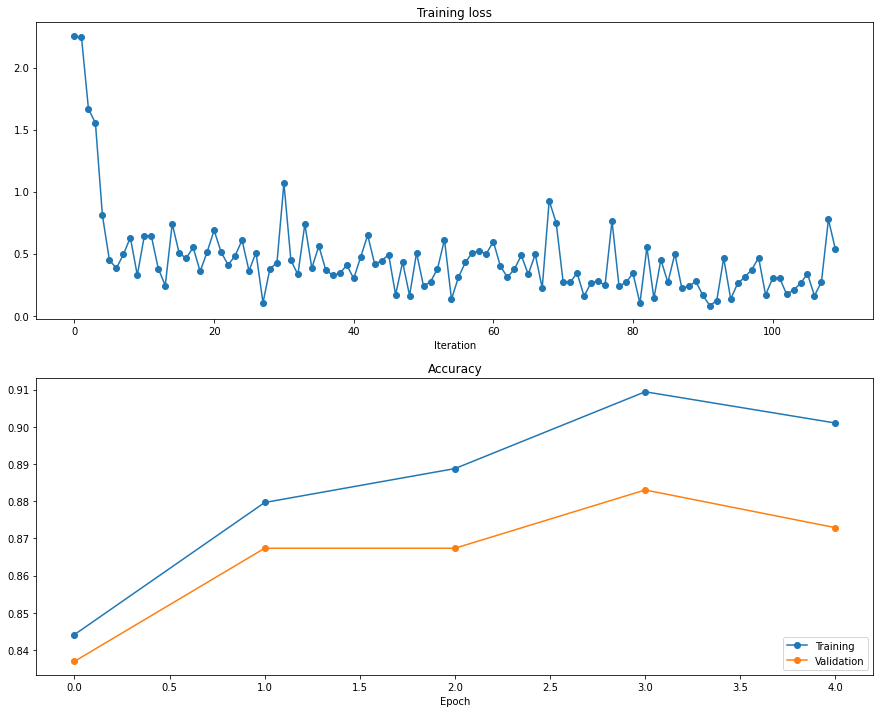

In [17]:
%reload_ext autoreload

opt_params, loss_hist, train_acc_hist, val_acc_hist = results

# Plot the learning curves
plt.subplot(2, 1, 1)
plt.title('Training loss')
loss_hist_ = loss_hist[1::100]  # sparse the curve a bit
plt.plot(loss_hist_, '-o')
plt.xlabel('Iteration')

plt.subplot(2, 1, 2)
plt.title('Accuracy')
plt.plot(train_acc_hist, '-o', label='Training')
plt.plot(val_acc_hist, '-o', label='Validation')
plt.xlabel('Epoch')
plt.legend(loc='lower right')
plt.gcf().set_size_inches(15, 12)

plt.show()

### Visualizing Layers [5pts]

An interesting finding from early research in convolutional networks was that the learned convolutions resembled filters used for things like edge detection. Complete the code below to visualize the filters in the first convolutional layer of your best model.

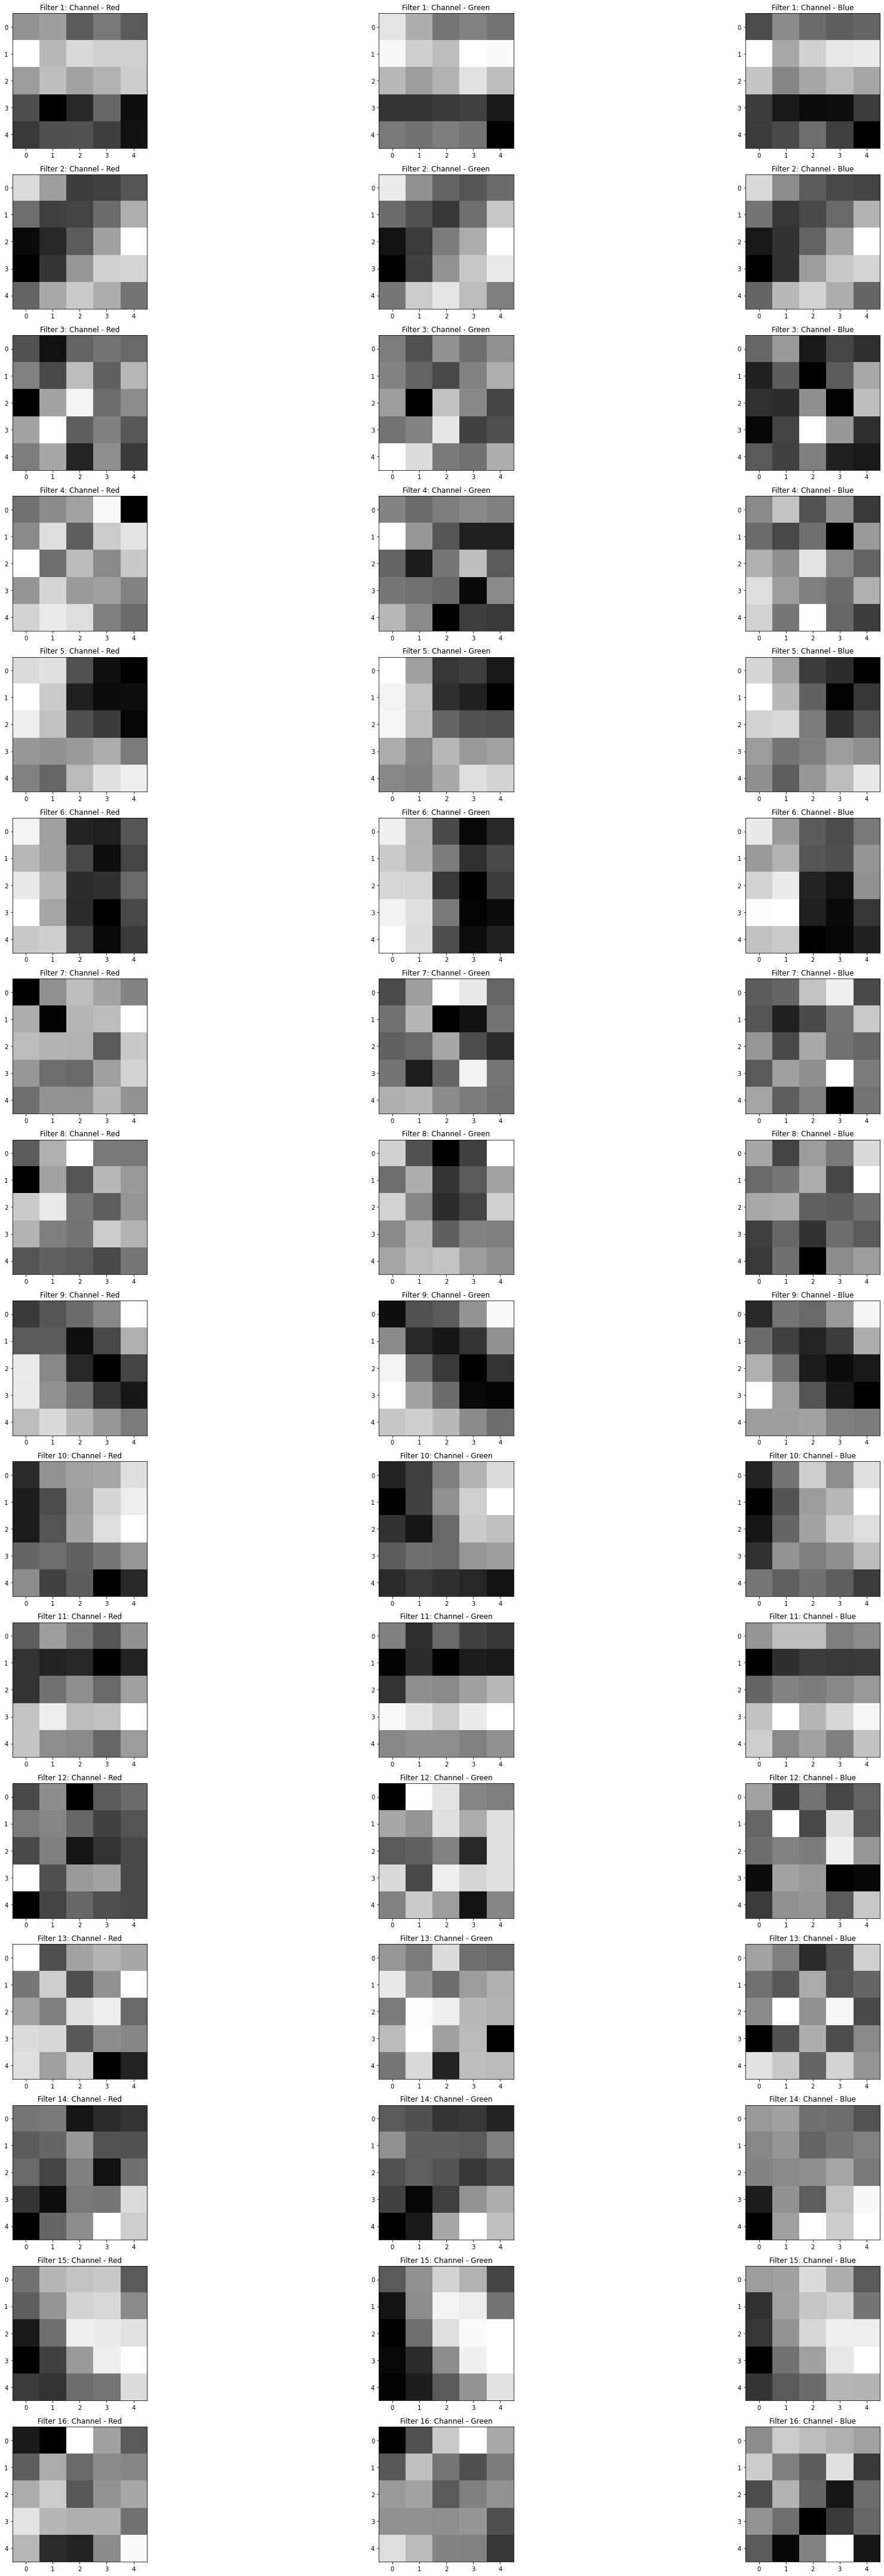

In [74]:
im_array = None
nrows, ncols = None, None

###################################################
# TODO: read the weights in the convolutional     #
# layer and reshape them to a grid of images to   #
# view with matplotlib.                           #
###################################################
filters = model.net.get_params("conv_w")
number_of_filters = filters.shape[3]
number_of_channels = 3
index=1
#min max normalization
filters = (filters - filters.min()) / (filters.max() - filters.min())

fig = plt.figure(figsize=(30,60))
for filter_index in range(number_of_filters):
    individual_filter = filters[:,:,:,filter_index]
    plt.subplot(number_of_filters,number_of_channels,index, title='Filter '+str(filter_index + 1)+': Channel - Red')
    plt.imshow(individual_filter[:,:,0] ,cmap='gray')
    index+=1
    plt.subplot(number_of_filters,number_of_channels,index, title='Filter '+str(filter_index + 1)+': Channel - Green')
    plt.imshow(individual_filter[:,:,1] ,cmap='gray')
    index+=1
    plt.subplot(number_of_filters,number_of_channels,index, title='Filter '+str(filter_index + 1)+': Channel - Blue')
    plt.imshow(individual_filter[:,:,2] ,cmap='gray')
    index+=1
plt.tight_layout(w_pad=1)
plt.show()
###################################################
#                END OF YOUR CODE                 #
###################################################

# plt.imshow(im_array)

#### Inline Question: Comment below on what kinds of filters you see. Include your response in your submission [5pts]

As can be seen from the filters above, the first convolutional layer learns certain representations from the data provided. The first convolutional layer of the SmallConvolutionalNetwork has 16 filters with 3 channels each. 

While it is a bit difficult to interpret the filters - we can still observe a few line detection filters in the plot. For instance, filters 2 and 9 look like line detectors since they have a light background with a dark diagonal line-like structure in the middle.

A few filters also resemble some edge detectors. For instance, filter 5 and 6 seem similar to vertical edge detectors and filter 11 looks similar to a horizontal edge detector. Filter 4 and 7 seem to be detecting individual points. Given the number of iterations and epochs that this model has currently been trained on, I believe there's still scope left for the model to show better filter visualizations as it learns more from the data and detects more patterns.

# Submission

Please prepare a PDF document `problem_2_solution.pdf` in the root directory of this repository with all plots and inline answers of your solution. Concretely, the document should contain the following items in strict order:
1. Training loss / accuracy curves for CNN training
2. Visualization of convolutional filters
3. Answers to inline questions about convolutional filters

Note that you still need to submit the jupyter notebook with all generated solutions. We will randomly pick submissions and check that the plots in the PDF and in the notebook are equivalent.